# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.419884119239465 -2.874304279107859
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [18]:
def model_loss(action_size, hidden_size, states, actions, targetQs):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions * targetQs)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossQ = tf.reduce_mean(tf.square(tf.reshape(Qs_logits, shape=[-1]) - targetQs))
    d_lossQsigm = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, shape=[-1]),
                                                                         labels=tf.nn.sigmoid(targetQs)))
    d_loss = d_lossQ + d_lossQsigm

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossQ, d_lossQsigm

In [19]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [20]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossQ, self.d_lossQsigm = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [30]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [31]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [32]:
# Training parameters
# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 32                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

In [33]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

In [34]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

In [35]:
memory.buffer[0]

[array([-0.03635973, -0.00867124, -0.04659109,  0.0024654 ]),
 1,
 array([-0.03653315,  0.18708686, -0.04654179, -0.30454593]),
 1.0,
 0.0]

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
from collections import deque
episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossQ_list, d_lossQsigm_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            # Testing/inference
            action_logits = sess.run(fetches=model.actions_logits, 
                                     feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state
            
            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            nextQs_logits = sess.run(fetches = model.Qs_logits,
                                     feed_dict = {model.states: next_states})
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # exploit
            targetQs = rewards + (0.99 * nextQs)
            g_loss, d_loss, d_lossQ, d_lossQsigm, _, _ = sess.run(
                fetches=[model.g_loss, model.d_loss, 
                         model.d_lossQ, model.d_lossQsigm,
                         model.g_opt, model.d_opt], 
                feed_dict = {model.states: states, 
                             model.actions: actions, 
                             model.targetQs: targetQs})
            if done is True:
                break

        # Episode total reward and success rate/prob
        episode_reward.append(total_reward) # stopping criteria
        rate = total_reward/ 500 # success is 500 points: 0-1
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossQ:{:.4f}'.format(d_lossQ),
              'dlossQsigm:{:.4f}'.format(d_lossQsigm))
        # Ploting out
        rewards_list.append([ep, np.mean(episode_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossQ_list.append([ep, d_lossQ])
        d_lossQsigm_list.append([ep, d_lossQsigm])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-copy1.ckpt')

Episode:0 meanR:9.0000 rate:0.0180 gloss:0.7840 dloss:1.6402 dlossQ:1.0261 dlossQsigm:0.6141
Episode:1 meanR:8.5000 rate:0.0160 gloss:0.8103 dloss:1.6609 dlossQ:1.1690 dlossQsigm:0.4919
Episode:2 meanR:8.6667 rate:0.0180 gloss:0.7021 dloss:2.3492 dlossQ:2.0225 dlossQsigm:0.3267
Episode:3 meanR:8.5000 rate:0.0160 gloss:0.1782 dloss:4.6675 dlossQ:4.3948 dlossQsigm:0.2727
Episode:4 meanR:8.4000 rate:0.0160 gloss:0.0658 dloss:10.3148 dlossQ:10.0031 dlossQsigm:0.3117
Episode:5 meanR:8.5000 rate:0.0180 gloss:0.0156 dloss:18.2525 dlossQ:17.8518 dlossQsigm:0.4008
Episode:6 meanR:8.5714 rate:0.0180 gloss:0.0044 dloss:15.2458 dlossQ:14.8775 dlossQsigm:0.3683
Episode:7 meanR:8.7500 rate:0.0200 gloss:0.0021 dloss:10.5667 dlossQ:10.2542 dlossQsigm:0.3126
Episode:8 meanR:8.7778 rate:0.0180 gloss:0.0014 dloss:9.3268 dlossQ:9.0307 dlossQsigm:0.2961
Episode:9 meanR:8.8000 rate:0.0180 gloss:0.0012 dloss:9.0969 dlossQ:8.8039 dlossQsigm:0.2930
Episode:10 meanR:8.9091 rate:0.0200 gloss:0.0009 dloss:8.4684 

Episode:92 meanR:9.3118 rate:0.0200 gloss:0.0000 dloss:0.2040 dlossQ:0.0388 dlossQsigm:0.1652
Episode:93 meanR:9.3191 rate:0.0200 gloss:0.0000 dloss:0.1990 dlossQ:0.0331 dlossQsigm:0.1659
Episode:94 meanR:9.3263 rate:0.0200 gloss:0.0000 dloss:0.1937 dlossQ:0.0288 dlossQsigm:0.1648
Episode:95 meanR:9.3333 rate:0.0200 gloss:0.0000 dloss:0.1740 dlossQ:0.0088 dlossQsigm:0.1652
Episode:96 meanR:9.3402 rate:0.0200 gloss:0.0000 dloss:0.1561 dlossQ:0.0019 dlossQsigm:0.1543
Episode:97 meanR:9.3469 rate:0.0200 gloss:0.0000 dloss:0.1533 dlossQ:0.0010 dlossQsigm:0.1524
Episode:98 meanR:9.3535 rate:0.0200 gloss:0.0000 dloss:0.1514 dlossQ:0.0011 dlossQsigm:0.1503
Episode:99 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1611 dlossQ:0.0056 dlossQsigm:0.1555
Episode:100 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1637 dlossQ:0.0055 dlossQsigm:0.1581
Episode:101 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1676 dlossQ:0.0125 dlossQsigm:0.1551
Episode:102 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.

Episode:181 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.2201 dlossQ:0.0424 dlossQsigm:0.1777
Episode:182 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1911 dlossQ:0.0468 dlossQsigm:0.1443
Episode:183 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.2226 dlossQ:0.0336 dlossQsigm:0.1890
Episode:184 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.1743 dlossQ:0.0099 dlossQsigm:0.1645
Episode:185 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1903 dlossQ:0.0177 dlossQsigm:0.1726
Episode:186 meanR:9.3600 rate:0.0160 gloss:0.0000 dloss:0.2125 dlossQ:0.0619 dlossQsigm:0.1506
Episode:187 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.2089 dlossQ:0.0366 dlossQsigm:0.1723
Episode:188 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.2016 dlossQ:0.0364 dlossQsigm:0.1652
Episode:189 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.1996 dlossQ:0.0258 dlossQsigm:0.1738
Episode:190 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1659 dlossQ:0.0192 dlossQsigm:0.1467
Episode:191 meanR:9.3400 rate:0.0200 gloss:0.0000 

Episode:269 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.3694 dlossQ:0.1345 dlossQsigm:0.2350
Episode:270 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1718 dlossQ:0.0055 dlossQsigm:0.1663
Episode:271 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1659 dlossQ:0.0187 dlossQsigm:0.1472
Episode:272 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1800 dlossQ:0.0133 dlossQsigm:0.1668
Episode:273 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.2214 dlossQ:0.0392 dlossQsigm:0.1822
Episode:274 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1513 dlossQ:0.0035 dlossQsigm:0.1478
Episode:275 meanR:9.3800 rate:0.0160 gloss:0.0000 dloss:0.1915 dlossQ:0.0333 dlossQsigm:0.1582
Episode:276 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1996 dlossQ:0.0285 dlossQsigm:0.1712
Episode:277 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.2067 dlossQ:0.0253 dlossQsigm:0.1815
Episode:278 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.2171 dlossQ:0.0331 dlossQsigm:0.1840
Episode:279 meanR:9.3800 rate:0.0180 gloss:0.0000 

Episode:360 meanR:9.4600 rate:0.0160 gloss:0.0000 dloss:0.1901 dlossQ:0.0445 dlossQsigm:0.1456
Episode:361 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.1999 dlossQ:0.0245 dlossQsigm:0.1754
Episode:362 meanR:9.4500 rate:0.0180 gloss:0.0000 dloss:0.2823 dlossQ:0.0704 dlossQsigm:0.2119
Episode:363 meanR:9.4300 rate:0.0160 gloss:0.0000 dloss:0.2229 dlossQ:0.0331 dlossQsigm:0.1898
Episode:364 meanR:9.4400 rate:0.0180 gloss:0.0000 dloss:0.1720 dlossQ:0.0136 dlossQsigm:0.1585
Episode:365 meanR:9.4100 rate:0.0160 gloss:0.0000 dloss:0.1746 dlossQ:0.0168 dlossQsigm:0.1578
Episode:366 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.1886 dlossQ:0.0148 dlossQsigm:0.1738
Episode:367 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.1902 dlossQ:0.0202 dlossQsigm:0.1699
Episode:368 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.1809 dlossQ:0.0207 dlossQsigm:0.1602
Episode:369 meanR:9.4200 rate:0.0180 gloss:0.0000 dloss:0.1943 dlossQ:0.0174 dlossQsigm:0.1769
Episode:370 meanR:9.4200 rate:0.0200 gloss:0.0000 

Episode:449 meanR:9.2300 rate:0.0220 gloss:0.0000 dloss:0.2242 dlossQ:0.0475 dlossQsigm:0.1767
Episode:450 meanR:9.2200 rate:0.0200 gloss:0.0000 dloss:0.1795 dlossQ:0.0461 dlossQsigm:0.1333
Episode:451 meanR:9.2100 rate:0.0180 gloss:0.0000 dloss:0.2116 dlossQ:0.0424 dlossQsigm:0.1692
Episode:452 meanR:9.2200 rate:0.0200 gloss:0.0000 dloss:0.2181 dlossQ:0.0426 dlossQsigm:0.1755
Episode:453 meanR:9.2300 rate:0.0200 gloss:0.0000 dloss:0.1652 dlossQ:0.0124 dlossQsigm:0.1528
Episode:454 meanR:9.2300 rate:0.0180 gloss:0.0000 dloss:0.1683 dlossQ:0.0089 dlossQsigm:0.1594
Episode:455 meanR:9.2300 rate:0.0180 gloss:0.0000 dloss:0.2153 dlossQ:0.0311 dlossQsigm:0.1841
Episode:456 meanR:9.2300 rate:0.0180 gloss:0.0000 dloss:0.2235 dlossQ:0.0341 dlossQsigm:0.1893
Episode:457 meanR:9.2400 rate:0.0200 gloss:0.0000 dloss:0.1610 dlossQ:0.0078 dlossQsigm:0.1532
Episode:458 meanR:9.2400 rate:0.0200 gloss:0.0000 dloss:0.2308 dlossQ:0.0436 dlossQsigm:0.1872
Episode:459 meanR:9.2500 rate:0.0200 gloss:0.0000 

Episode:541 meanR:9.4800 rate:0.0180 gloss:0.0000 dloss:0.1777 dlossQ:0.0105 dlossQsigm:0.1672
Episode:542 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.2015 dlossQ:0.0251 dlossQsigm:0.1764
Episode:543 meanR:9.5100 rate:0.0200 gloss:0.0000 dloss:0.1974 dlossQ:0.0243 dlossQsigm:0.1731
Episode:544 meanR:9.5200 rate:0.0180 gloss:0.0000 dloss:0.1665 dlossQ:0.0073 dlossQsigm:0.1592
Episode:545 meanR:9.5200 rate:0.0180 gloss:0.0000 dloss:0.1720 dlossQ:0.0088 dlossQsigm:0.1632
Episode:546 meanR:9.5000 rate:0.0180 gloss:0.0000 dloss:0.1952 dlossQ:0.0195 dlossQsigm:0.1758
Episode:547 meanR:9.5200 rate:0.0220 gloss:0.0000 dloss:0.3045 dlossQ:0.0989 dlossQsigm:0.2056
Episode:548 meanR:9.5000 rate:0.0160 gloss:0.0000 dloss:0.2632 dlossQ:0.0737 dlossQsigm:0.1894
Episode:549 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.2227 dlossQ:0.0518 dlossQsigm:0.1709
Episode:550 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.2701 dlossQ:0.0737 dlossQsigm:0.1963
Episode:551 meanR:9.4900 rate:0.0180 gloss:0.0000 

Episode:633 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1915 dlossQ:0.0146 dlossQsigm:0.1769
Episode:634 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.1951 dlossQ:0.0178 dlossQsigm:0.1773
Episode:635 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.1659 dlossQ:0.0045 dlossQsigm:0.1614
Episode:636 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.2303 dlossQ:0.0389 dlossQsigm:0.1913
Episode:637 meanR:9.2700 rate:0.0160 gloss:0.0000 dloss:0.1900 dlossQ:0.0265 dlossQsigm:0.1634
Episode:638 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.2915 dlossQ:0.0853 dlossQsigm:0.2062
Episode:639 meanR:9.2700 rate:0.0160 gloss:0.0000 dloss:0.2606 dlossQ:0.0659 dlossQsigm:0.1947
Episode:640 meanR:9.2700 rate:0.0200 gloss:0.0000 dloss:0.2293 dlossQ:0.0545 dlossQsigm:0.1748
Episode:641 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.2107 dlossQ:0.0296 dlossQsigm:0.1811
Episode:642 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.2623 dlossQ:0.0664 dlossQsigm:0.1959
Episode:643 meanR:9.2600 rate:0.0180 gloss:0.0000 

Episode:720 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.1660 dlossQ:0.0129 dlossQsigm:0.1531
Episode:721 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.2049 dlossQ:0.0308 dlossQsigm:0.1741
Episode:722 meanR:9.4700 rate:0.0180 gloss:0.0000 dloss:0.2170 dlossQ:0.0351 dlossQsigm:0.1820
Episode:723 meanR:9.4800 rate:0.0200 gloss:0.0000 dloss:0.1857 dlossQ:0.0172 dlossQsigm:0.1685
Episode:724 meanR:9.4800 rate:0.0200 gloss:0.0000 dloss:0.2498 dlossQ:0.0568 dlossQsigm:0.1931
Episode:725 meanR:9.4700 rate:0.0160 gloss:0.0000 dloss:0.1978 dlossQ:0.0275 dlossQsigm:0.1703
Episode:726 meanR:9.4700 rate:0.0180 gloss:0.0000 dloss:0.1843 dlossQ:0.0196 dlossQsigm:0.1647
Episode:727 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.2051 dlossQ:0.0268 dlossQsigm:0.1782
Episode:728 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.2385 dlossQ:0.0432 dlossQsigm:0.1953
Episode:729 meanR:9.4500 rate:0.0180 gloss:0.0000 dloss:0.1863 dlossQ:0.0149 dlossQsigm:0.1714
Episode:730 meanR:9.4400 rate:0.0180 gloss:0.0000 

Episode:810 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.1900 dlossQ:0.0246 dlossQsigm:0.1655
Episode:811 meanR:9.4400 rate:0.0180 gloss:0.0000 dloss:0.1662 dlossQ:0.0099 dlossQsigm:0.1563
Episode:812 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.1768 dlossQ:0.0116 dlossQsigm:0.1652
Episode:813 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.1802 dlossQ:0.0111 dlossQsigm:0.1691
Episode:814 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.1559 dlossQ:0.0057 dlossQsigm:0.1502
Episode:815 meanR:9.4400 rate:0.0180 gloss:0.0000 dloss:0.2105 dlossQ:0.0293 dlossQsigm:0.1811
Episode:816 meanR:9.4500 rate:0.0220 gloss:0.0000 dloss:0.1752 dlossQ:0.0128 dlossQsigm:0.1624
Episode:817 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.1749 dlossQ:0.0138 dlossQsigm:0.1610
Episode:818 meanR:9.4500 rate:0.0160 gloss:0.0000 dloss:0.1892 dlossQ:0.0361 dlossQsigm:0.1531
Episode:819 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.2157 dlossQ:0.0382 dlossQsigm:0.1775
Episode:820 meanR:9.4500 rate:0.0200 gloss:0.0000 

Episode:898 meanR:9.6000 rate:0.0220 gloss:0.0000 dloss:0.2091 dlossQ:0.0354 dlossQsigm:0.1737
Episode:899 meanR:9.5900 rate:0.0180 gloss:0.0000 dloss:0.1925 dlossQ:0.0351 dlossQsigm:0.1575
Episode:900 meanR:9.6000 rate:0.0200 gloss:0.0000 dloss:0.1743 dlossQ:0.0214 dlossQsigm:0.1528
Episode:901 meanR:9.6000 rate:0.0200 gloss:0.0000 dloss:0.2536 dlossQ:0.0629 dlossQsigm:0.1907
Episode:902 meanR:9.5900 rate:0.0160 gloss:0.0000 dloss:0.2827 dlossQ:0.0762 dlossQsigm:0.2065
Episode:903 meanR:9.5800 rate:0.0160 gloss:0.0000 dloss:0.1659 dlossQ:0.0107 dlossQsigm:0.1552
Episode:904 meanR:9.5800 rate:0.0200 gloss:0.0000 dloss:0.2320 dlossQ:0.0428 dlossQsigm:0.1892
Episode:905 meanR:9.5700 rate:0.0180 gloss:0.0000 dloss:0.1975 dlossQ:0.0307 dlossQsigm:0.1667
Episode:906 meanR:9.5800 rate:0.0200 gloss:0.0000 dloss:0.2277 dlossQ:0.0774 dlossQsigm:0.1504
Episode:907 meanR:9.5800 rate:0.0200 gloss:0.0000 dloss:0.4164 dlossQ:0.1889 dlossQsigm:0.2276
Episode:908 meanR:9.5800 rate:0.0200 gloss:0.0000 

Episode:990 meanR:9.5600 rate:0.0200 gloss:0.0000 dloss:0.1932 dlossQ:0.0161 dlossQsigm:0.1771
Episode:991 meanR:9.5500 rate:0.0180 gloss:0.0000 dloss:0.1925 dlossQ:0.0155 dlossQsigm:0.1770
Episode:992 meanR:9.5500 rate:0.0200 gloss:0.0000 dloss:0.1901 dlossQ:0.0193 dlossQsigm:0.1708
Episode:993 meanR:9.5400 rate:0.0180 gloss:0.0000 dloss:0.1740 dlossQ:0.0189 dlossQsigm:0.1551
Episode:994 meanR:9.5300 rate:0.0180 gloss:0.0000 dloss:0.1719 dlossQ:0.0200 dlossQsigm:0.1519
Episode:995 meanR:9.5300 rate:0.0180 gloss:0.0000 dloss:0.1810 dlossQ:0.0071 dlossQsigm:0.1739
Episode:996 meanR:9.5200 rate:0.0180 gloss:0.0000 dloss:0.1660 dlossQ:0.0189 dlossQsigm:0.1471
Episode:997 meanR:9.5200 rate:0.0180 gloss:0.0000 dloss:0.1621 dlossQ:0.0104 dlossQsigm:0.1517
Episode:998 meanR:9.5100 rate:0.0200 gloss:0.0000 dloss:0.1765 dlossQ:0.0067 dlossQsigm:0.1699
Episode:999 meanR:9.5100 rate:0.0180 gloss:0.0000 dloss:0.1762 dlossQ:0.0071 dlossQsigm:0.1690
Episode:1000 meanR:9.5000 rate:0.0180 gloss:0.0000

Episode:1076 meanR:9.3500 rate:0.0160 gloss:0.0000 dloss:0.1895 dlossQ:0.0177 dlossQsigm:0.1717
Episode:1077 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1755 dlossQ:0.0137 dlossQsigm:0.1618
Episode:1078 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1777 dlossQ:0.0122 dlossQsigm:0.1654
Episode:1079 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1779 dlossQ:0.0083 dlossQsigm:0.1696
Episode:1080 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1773 dlossQ:0.0072 dlossQsigm:0.1702
Episode:1081 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1778 dlossQ:0.0095 dlossQsigm:0.1683
Episode:1082 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1752 dlossQ:0.0141 dlossQsigm:0.1611
Episode:1083 meanR:9.3300 rate:0.0160 gloss:0.0000 dloss:0.1817 dlossQ:0.0238 dlossQsigm:0.1579
Episode:1084 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.2035 dlossQ:0.0276 dlossQsigm:0.1759
Episode:1085 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.2164 dlossQ:0.0372 dlossQsigm:0.1793
Episode:1086 meanR:9.3400 rate:0.0200 gl

Episode:1163 meanR:9.2700 rate:0.0200 gloss:0.0000 dloss:0.1863 dlossQ:0.0157 dlossQsigm:0.1707
Episode:1164 meanR:9.2900 rate:0.0220 gloss:0.0000 dloss:0.2484 dlossQ:0.0627 dlossQsigm:0.1858
Episode:1165 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1664 dlossQ:0.0258 dlossQsigm:0.1407
Episode:1166 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1717 dlossQ:0.0229 dlossQsigm:0.1488
Episode:1167 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1793 dlossQ:0.0187 dlossQsigm:0.1605
Episode:1168 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.1878 dlossQ:0.0102 dlossQsigm:0.1776
Episode:1169 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1614 dlossQ:0.0030 dlossQsigm:0.1584
Episode:1170 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.1597 dlossQ:0.0065 dlossQsigm:0.1531
Episode:1171 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1827 dlossQ:0.0112 dlossQsigm:0.1714
Episode:1172 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1782 dlossQ:0.0276 dlossQsigm:0.1505
Episode:1173 meanR:9.2700 rate:0.0200 gl

Episode:1253 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1930 dlossQ:0.0163 dlossQsigm:0.1767
Episode:1254 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1656 dlossQ:0.0116 dlossQsigm:0.1539
Episode:1255 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1797 dlossQ:0.0107 dlossQsigm:0.1689
Episode:1256 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1975 dlossQ:0.0168 dlossQsigm:0.1806
Episode:1257 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1864 dlossQ:0.0143 dlossQsigm:0.1721
Episode:1258 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1676 dlossQ:0.0083 dlossQsigm:0.1593
Episode:1259 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.2168 dlossQ:0.0357 dlossQsigm:0.1811
Episode:1260 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1660 dlossQ:0.0250 dlossQsigm:0.1410
Episode:1261 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1761 dlossQ:0.0275 dlossQsigm:0.1486
Episode:1262 meanR:9.3500 rate:0.0220 gloss:0.0000 dloss:0.2315 dlossQ:0.0550 dlossQsigm:0.1765
Episode:1263 meanR:9.3400 rate:0.0180 gl

Episode:1343 meanR:9.4500 rate:0.0220 gloss:0.0000 dloss:0.2532 dlossQ:0.0625 dlossQsigm:0.1907
Episode:1344 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.1606 dlossQ:0.0151 dlossQsigm:0.1455
Episode:1345 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.1525 dlossQ:0.0123 dlossQsigm:0.1402
Episode:1346 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.1745 dlossQ:0.0153 dlossQsigm:0.1591
Episode:1347 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.1520 dlossQ:0.0087 dlossQsigm:0.1433
Episode:1348 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.1659 dlossQ:0.0104 dlossQsigm:0.1556
Episode:1349 meanR:9.4500 rate:0.0160 gloss:0.0000 dloss:0.1816 dlossQ:0.0173 dlossQsigm:0.1643
Episode:1350 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.2032 dlossQ:0.0278 dlossQsigm:0.1753
Episode:1351 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.1854 dlossQ:0.0308 dlossQsigm:0.1547
Episode:1352 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.1855 dlossQ:0.0261 dlossQsigm:0.1594
Episode:1353 meanR:9.4700 rate:0.0200 gl

Episode:1433 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.1736 dlossQ:0.0195 dlossQsigm:0.1542
Episode:1434 meanR:9.4800 rate:0.0180 gloss:0.0000 dloss:0.1713 dlossQ:0.0113 dlossQsigm:0.1600
Episode:1435 meanR:9.4700 rate:0.0180 gloss:0.0000 dloss:0.1655 dlossQ:0.0150 dlossQsigm:0.1505
Episode:1436 meanR:9.4800 rate:0.0220 gloss:0.0000 dloss:0.2354 dlossQ:0.0467 dlossQsigm:0.1887
Episode:1437 meanR:9.4700 rate:0.0180 gloss:0.0000 dloss:0.1759 dlossQ:0.0249 dlossQsigm:0.1510
Episode:1438 meanR:9.4800 rate:0.0180 gloss:0.0000 dloss:0.1807 dlossQ:0.0206 dlossQsigm:0.1601
Episode:1439 meanR:9.4900 rate:0.0180 gloss:0.0000 dloss:0.1927 dlossQ:0.0192 dlossQsigm:0.1736
Episode:1440 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.1840 dlossQ:0.0129 dlossQsigm:0.1711
Episode:1441 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.1691 dlossQ:0.0232 dlossQsigm:0.1459
Episode:1442 meanR:9.4900 rate:0.0180 gloss:0.0000 dloss:0.1981 dlossQ:0.0275 dlossQsigm:0.1706
Episode:1443 meanR:9.4700 rate:0.0180 gl

Episode:1521 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1766 dlossQ:0.0088 dlossQsigm:0.1678
Episode:1522 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1687 dlossQ:0.0056 dlossQsigm:0.1631
Episode:1523 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1689 dlossQ:0.0093 dlossQsigm:0.1596
Episode:1524 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1723 dlossQ:0.0100 dlossQsigm:0.1623
Episode:1525 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1969 dlossQ:0.0211 dlossQsigm:0.1758
Episode:1526 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.2144 dlossQ:0.0317 dlossQsigm:0.1828
Episode:1527 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1876 dlossQ:0.0431 dlossQsigm:0.1445
Episode:1528 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1645 dlossQ:0.0081 dlossQsigm:0.1564
Episode:1529 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1847 dlossQ:0.0101 dlossQsigm:0.1746
Episode:1530 meanR:9.3600 rate:0.0160 gloss:0.0000 dloss:0.1881 dlossQ:0.0149 dlossQsigm:0.1732
Episode:1531 meanR:9.3300 rate:0.0160 gl

Episode:1608 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1738 dlossQ:0.0154 dlossQsigm:0.1584
Episode:1609 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1933 dlossQ:0.0201 dlossQsigm:0.1732
Episode:1610 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1795 dlossQ:0.0102 dlossQsigm:0.1693
Episode:1611 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1568 dlossQ:0.0036 dlossQsigm:0.1532
Episode:1612 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1627 dlossQ:0.0100 dlossQsigm:0.1526
Episode:1613 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1633 dlossQ:0.0094 dlossQsigm:0.1540
Episode:1614 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.2006 dlossQ:0.0213 dlossQsigm:0.1793
Episode:1615 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1695 dlossQ:0.0067 dlossQsigm:0.1627
Episode:1616 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.2165 dlossQ:0.0789 dlossQsigm:0.1376
Episode:1617 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1991 dlossQ:0.0212 dlossQsigm:0.1779
Episode:1618 meanR:9.3600 rate:0.0180 gl

Episode:1698 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.2137 dlossQ:0.0321 dlossQsigm:0.1817
Episode:1699 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.1804 dlossQ:0.0442 dlossQsigm:0.1362
Episode:1700 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1779 dlossQ:0.0106 dlossQsigm:0.1673
Episode:1701 meanR:9.2900 rate:0.0160 gloss:0.0000 dloss:0.2269 dlossQ:0.0386 dlossQsigm:0.1883
Episode:1702 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1991 dlossQ:0.0184 dlossQsigm:0.1807
Episode:1703 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1647 dlossQ:0.0073 dlossQsigm:0.1574
Episode:1704 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.1703 dlossQ:0.0074 dlossQsigm:0.1629
Episode:1705 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1672 dlossQ:0.0110 dlossQsigm:0.1562
Episode:1706 meanR:9.2700 rate:0.0200 gloss:0.0000 dloss:0.2037 dlossQ:0.0240 dlossQsigm:0.1797
Episode:1707 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.1944 dlossQ:0.0177 dlossQsigm:0.1766
Episode:1708 meanR:9.2600 rate:0.0200 gl

Episode:1786 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1869 dlossQ:0.0153 dlossQsigm:0.1717
Episode:1787 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1761 dlossQ:0.0279 dlossQsigm:0.1482
Episode:1788 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1685 dlossQ:0.0208 dlossQsigm:0.1478
Episode:1789 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1913 dlossQ:0.0161 dlossQsigm:0.1752
Episode:1790 meanR:9.3900 rate:0.0160 gloss:0.0000 dloss:0.1758 dlossQ:0.0156 dlossQsigm:0.1603
Episode:1791 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1838 dlossQ:0.0150 dlossQsigm:0.1689
Episode:1792 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1786 dlossQ:0.0134 dlossQsigm:0.1652
Episode:1793 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1909 dlossQ:0.0161 dlossQsigm:0.1749
Episode:1794 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1708 dlossQ:0.0192 dlossQsigm:0.1516
Episode:1795 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1722 dlossQ:0.0215 dlossQsigm:0.1507
Episode:1796 meanR:9.4000 rate:0.0200 gl

Episode:1879 meanR:9.4300 rate:0.0220 gloss:0.0000 dloss:0.1840 dlossQ:0.0243 dlossQsigm:0.1597
Episode:1880 meanR:9.4200 rate:0.0180 gloss:0.0000 dloss:0.1941 dlossQ:0.0470 dlossQsigm:0.1472
Episode:1881 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.2066 dlossQ:0.0686 dlossQsigm:0.1380
Episode:1882 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.1994 dlossQ:0.0217 dlossQsigm:0.1777
Episode:1883 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.1975 dlossQ:0.0183 dlossQsigm:0.1792
Episode:1884 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.1833 dlossQ:0.0117 dlossQsigm:0.1716
Episode:1885 meanR:9.3900 rate:0.0160 gloss:0.0000 dloss:0.1864 dlossQ:0.0374 dlossQsigm:0.1490
Episode:1886 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1781 dlossQ:0.0153 dlossQsigm:0.1628
Episode:1887 meanR:9.4000 rate:0.0220 gloss:0.0000 dloss:0.3205 dlossQ:0.1035 dlossQsigm:0.2170
Episode:1888 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.2450 dlossQ:0.0490 dlossQsigm:0.1960
Episode:1889 meanR:9.3900 rate:0.0180 gl

Episode:1970 meanR:9.3500 rate:0.0160 gloss:0.0000 dloss:0.1683 dlossQ:0.0148 dlossQsigm:0.1535
Episode:1971 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1942 dlossQ:0.0207 dlossQsigm:0.1735
Episode:1972 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.2122 dlossQ:0.0316 dlossQsigm:0.1806
Episode:1973 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1788 dlossQ:0.0218 dlossQsigm:0.1570
Episode:1974 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1882 dlossQ:0.0239 dlossQsigm:0.1642
Episode:1975 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1829 dlossQ:0.0276 dlossQsigm:0.1552
Episode:1976 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.1762 dlossQ:0.0285 dlossQsigm:0.1477
Episode:1977 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1570 dlossQ:0.0092 dlossQsigm:0.1478
Episode:1978 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.1590 dlossQ:0.0091 dlossQsigm:0.1499
Episode:1979 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1750 dlossQ:0.0095 dlossQsigm:0.1655
Episode:1980 meanR:9.3700 rate:0.0160 gl

Episode:2059 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1740 dlossQ:0.0072 dlossQsigm:0.1668
Episode:2060 meanR:9.3300 rate:0.0160 gloss:0.0000 dloss:0.1673 dlossQ:0.0078 dlossQsigm:0.1595
Episode:2061 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1831 dlossQ:0.0108 dlossQsigm:0.1723
Episode:2062 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1789 dlossQ:0.0093 dlossQsigm:0.1696
Episode:2063 meanR:9.3400 rate:0.0160 gloss:0.0000 dloss:0.1669 dlossQ:0.0105 dlossQsigm:0.1563
Episode:2064 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1741 dlossQ:0.0099 dlossQsigm:0.1641
Episode:2065 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.2083 dlossQ:0.0257 dlossQsigm:0.1826
Episode:2066 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1814 dlossQ:0.0188 dlossQsigm:0.1626
Episode:2067 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1869 dlossQ:0.0131 dlossQsigm:0.1738
Episode:2068 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1591 dlossQ:0.0060 dlossQsigm:0.1531
Episode:2069 meanR:9.3400 rate:0.0180 gl

Episode:2151 meanR:9.2900 rate:0.0160 gloss:0.0000 dloss:0.1785 dlossQ:0.0328 dlossQsigm:0.1458
Episode:2152 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1772 dlossQ:0.0128 dlossQsigm:0.1644
Episode:2153 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.2022 dlossQ:0.0213 dlossQsigm:0.1809
Episode:2154 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1800 dlossQ:0.0123 dlossQsigm:0.1677
Episode:2155 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1610 dlossQ:0.0024 dlossQsigm:0.1586
Episode:2156 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1772 dlossQ:0.0077 dlossQsigm:0.1695
Episode:2157 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1869 dlossQ:0.0176 dlossQsigm:0.1693
Episode:2158 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1819 dlossQ:0.0181 dlossQsigm:0.1638
Episode:2159 meanR:9.3200 rate:0.0160 gloss:0.0000 dloss:0.1948 dlossQ:0.0454 dlossQsigm:0.1494
Episode:2160 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.2068 dlossQ:0.0315 dlossQsigm:0.1754
Episode:2161 meanR:9.3400 rate:0.0200 gl

Episode:2239 meanR:9.2500 rate:0.0180 gloss:0.0000 dloss:0.1804 dlossQ:0.0081 dlossQsigm:0.1722
Episode:2240 meanR:9.2400 rate:0.0180 gloss:0.0000 dloss:0.1639 dlossQ:0.0055 dlossQsigm:0.1585
Episode:2241 meanR:9.2300 rate:0.0160 gloss:0.0000 dloss:0.1654 dlossQ:0.0097 dlossQsigm:0.1557
Episode:2242 meanR:9.2300 rate:0.0200 gloss:0.0000 dloss:0.2189 dlossQ:0.0351 dlossQsigm:0.1838
Episode:2243 meanR:9.2500 rate:0.0200 gloss:0.0000 dloss:0.1926 dlossQ:0.0242 dlossQsigm:0.1683
Episode:2244 meanR:9.2500 rate:0.0180 gloss:0.0000 dloss:0.1817 dlossQ:0.0349 dlossQsigm:0.1468
Episode:2245 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.1695 dlossQ:0.0147 dlossQsigm:0.1547
Episode:2246 meanR:9.2500 rate:0.0160 gloss:0.0000 dloss:0.1694 dlossQ:0.0087 dlossQsigm:0.1608
Episode:2247 meanR:9.2500 rate:0.0200 gloss:0.0000 dloss:0.1863 dlossQ:0.0130 dlossQsigm:0.1732
Episode:2248 meanR:9.2500 rate:0.0160 gloss:0.0000 dloss:0.1771 dlossQ:0.0143 dlossQsigm:0.1628
Episode:2249 meanR:9.2400 rate:0.0160 gl

Episode:2328 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.2005 dlossQ:0.0204 dlossQsigm:0.1800
Episode:2329 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1827 dlossQ:0.0112 dlossQsigm:0.1715
Episode:2330 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1614 dlossQ:0.0081 dlossQsigm:0.1533
Episode:2331 meanR:9.3200 rate:0.0160 gloss:0.0000 dloss:0.1768 dlossQ:0.0216 dlossQsigm:0.1552
Episode:2332 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1852 dlossQ:0.0152 dlossQsigm:0.1700
Episode:2333 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1861 dlossQ:0.0162 dlossQsigm:0.1698
Episode:2334 meanR:9.3200 rate:0.0160 gloss:0.0000 dloss:0.1784 dlossQ:0.0165 dlossQsigm:0.1619
Episode:2335 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1692 dlossQ:0.0174 dlossQsigm:0.1519
Episode:2336 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1878 dlossQ:0.0133 dlossQsigm:0.1746
Episode:2337 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1707 dlossQ:0.0072 dlossQsigm:0.1634
Episode:2338 meanR:9.3300 rate:0.0200 gl

Episode:2414 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1686 dlossQ:0.0121 dlossQsigm:0.1564
Episode:2415 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1719 dlossQ:0.0126 dlossQsigm:0.1593
Episode:2416 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1737 dlossQ:0.0054 dlossQsigm:0.1682
Episode:2417 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1645 dlossQ:0.0050 dlossQsigm:0.1594
Episode:2418 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1576 dlossQ:0.0045 dlossQsigm:0.1531
Episode:2419 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1676 dlossQ:0.0074 dlossQsigm:0.1602
Episode:2420 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1659 dlossQ:0.0086 dlossQsigm:0.1573
Episode:2421 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1751 dlossQ:0.0096 dlossQsigm:0.1654
Episode:2422 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1761 dlossQ:0.0097 dlossQsigm:0.1664
Episode:2423 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1718 dlossQ:0.0048 dlossQsigm:0.1670
Episode:2424 meanR:9.3000 rate:0.0200 gl

Episode:2503 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1686 dlossQ:0.0170 dlossQsigm:0.1516
Episode:2504 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.1669 dlossQ:0.0122 dlossQsigm:0.1547
Episode:2505 meanR:9.3500 rate:0.0160 gloss:0.0000 dloss:0.1761 dlossQ:0.0064 dlossQsigm:0.1696
Episode:2506 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1853 dlossQ:0.0108 dlossQsigm:0.1745
Episode:2507 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1924 dlossQ:0.0195 dlossQsigm:0.1729
Episode:2508 meanR:9.3700 rate:0.0160 gloss:0.0000 dloss:0.1901 dlossQ:0.0308 dlossQsigm:0.1593
Episode:2509 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1992 dlossQ:0.0538 dlossQsigm:0.1453
Episode:2510 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1960 dlossQ:0.0255 dlossQsigm:0.1704
Episode:2511 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.2099 dlossQ:0.0255 dlossQsigm:0.1844
Episode:2512 meanR:9.3500 rate:0.0160 gloss:0.0000 dloss:0.1720 dlossQ:0.0103 dlossQsigm:0.1618
Episode:2513 meanR:9.3600 rate:0.0200 gl

Episode:2592 meanR:9.1400 rate:0.0200 gloss:0.0000 dloss:0.1747 dlossQ:0.0156 dlossQsigm:0.1591
Episode:2593 meanR:9.1500 rate:0.0200 gloss:0.0000 dloss:0.1584 dlossQ:0.0159 dlossQsigm:0.1425
Episode:2594 meanR:9.1400 rate:0.0160 gloss:0.0000 dloss:0.1709 dlossQ:0.0262 dlossQsigm:0.1447
Episode:2595 meanR:9.1200 rate:0.0160 gloss:0.0000 dloss:0.1853 dlossQ:0.0434 dlossQsigm:0.1420
Episode:2596 meanR:9.1200 rate:0.0180 gloss:0.0000 dloss:0.1724 dlossQ:0.0106 dlossQsigm:0.1618
Episode:2597 meanR:9.1200 rate:0.0180 gloss:0.0000 dloss:0.1761 dlossQ:0.0145 dlossQsigm:0.1616
Episode:2598 meanR:9.1200 rate:0.0200 gloss:0.0000 dloss:0.1861 dlossQ:0.0163 dlossQsigm:0.1698
Episode:2599 meanR:9.1300 rate:0.0180 gloss:0.0000 dloss:0.1727 dlossQ:0.0111 dlossQsigm:0.1616
Episode:2600 meanR:9.1400 rate:0.0200 gloss:0.0000 dloss:0.1685 dlossQ:0.0093 dlossQsigm:0.1592
Episode:2601 meanR:9.1300 rate:0.0180 gloss:0.0000 dloss:0.1617 dlossQ:0.0020 dlossQsigm:0.1597
Episode:2602 meanR:9.1200 rate:0.0180 gl

Episode:2681 meanR:9.1700 rate:0.0180 gloss:0.0000 dloss:0.1645 dlossQ:0.0110 dlossQsigm:0.1535
Episode:2682 meanR:9.1600 rate:0.0180 gloss:0.0000 dloss:0.1697 dlossQ:0.0060 dlossQsigm:0.1637
Episode:2683 meanR:9.1600 rate:0.0180 gloss:0.0000 dloss:0.1674 dlossQ:0.0130 dlossQsigm:0.1545
Episode:2684 meanR:9.1900 rate:0.0220 gloss:0.0000 dloss:0.2261 dlossQ:0.0407 dlossQsigm:0.1854
Episode:2685 meanR:9.2100 rate:0.0200 gloss:0.0000 dloss:0.1784 dlossQ:0.0165 dlossQsigm:0.1619
Episode:2686 meanR:9.2200 rate:0.0200 gloss:0.0000 dloss:0.1612 dlossQ:0.0131 dlossQsigm:0.1481
Episode:2687 meanR:9.2200 rate:0.0180 gloss:0.0000 dloss:0.1659 dlossQ:0.0120 dlossQsigm:0.1539
Episode:2688 meanR:9.2400 rate:0.0200 gloss:0.0000 dloss:0.1603 dlossQ:0.0082 dlossQsigm:0.1521
Episode:2689 meanR:9.2300 rate:0.0200 gloss:0.0000 dloss:0.1680 dlossQ:0.0111 dlossQsigm:0.1569
Episode:2690 meanR:9.2300 rate:0.0200 gloss:0.0000 dloss:0.1796 dlossQ:0.0151 dlossQsigm:0.1645
Episode:2691 meanR:9.2200 rate:0.0180 gl

Episode:2770 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.2153 dlossQ:0.0305 dlossQsigm:0.1848
Episode:2771 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1762 dlossQ:0.0211 dlossQsigm:0.1551
Episode:2772 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1691 dlossQ:0.0207 dlossQsigm:0.1485
Episode:2773 meanR:9.3400 rate:0.0160 gloss:0.0000 dloss:0.1817 dlossQ:0.0371 dlossQsigm:0.1445
Episode:2774 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.2195 dlossQ:0.0316 dlossQsigm:0.1879
Episode:2775 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.2118 dlossQ:0.0239 dlossQsigm:0.1878
Episode:2776 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1707 dlossQ:0.0124 dlossQsigm:0.1583
Episode:2777 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1627 dlossQ:0.0107 dlossQsigm:0.1520
Episode:2778 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1726 dlossQ:0.0071 dlossQsigm:0.1654
Episode:2779 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1657 dlossQ:0.0043 dlossQsigm:0.1615
Episode:2780 meanR:9.3200 rate:0.0180 gl

Episode:2858 meanR:9.3300 rate:0.0160 gloss:0.0000 dloss:0.1742 dlossQ:0.0242 dlossQsigm:0.1499
Episode:2859 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1767 dlossQ:0.0145 dlossQsigm:0.1622
Episode:2860 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1878 dlossQ:0.0120 dlossQsigm:0.1758
Episode:2861 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1931 dlossQ:0.0151 dlossQsigm:0.1780
Episode:2862 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1625 dlossQ:0.0018 dlossQsigm:0.1608
Episode:2863 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1625 dlossQ:0.0058 dlossQsigm:0.1566
Episode:2864 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1640 dlossQ:0.0057 dlossQsigm:0.1583
Episode:2865 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.1708 dlossQ:0.0051 dlossQsigm:0.1657
Episode:2866 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1884 dlossQ:0.0133 dlossQsigm:0.1750
Episode:2867 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1626 dlossQ:0.0062 dlossQsigm:0.1564
Episode:2868 meanR:9.2800 rate:0.0180 gl

Episode:2945 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1718 dlossQ:0.0135 dlossQsigm:0.1584
Episode:2946 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1736 dlossQ:0.0081 dlossQsigm:0.1656
Episode:2947 meanR:9.3100 rate:0.0160 gloss:0.0000 dloss:0.1824 dlossQ:0.0300 dlossQsigm:0.1524
Episode:2948 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1816 dlossQ:0.0212 dlossQsigm:0.1604
Episode:2949 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.2118 dlossQ:0.0259 dlossQsigm:0.1859
Episode:2950 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1936 dlossQ:0.0162 dlossQsigm:0.1774
Episode:2951 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1637 dlossQ:0.0044 dlossQsigm:0.1593
Episode:2952 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1623 dlossQ:0.0061 dlossQsigm:0.1561
Episode:2953 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1774 dlossQ:0.0059 dlossQsigm:0.1715
Episode:2954 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1620 dlossQ:0.0030 dlossQsigm:0.1589
Episode:2955 meanR:9.3000 rate:0.0200 gl

Episode:3034 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.2292 dlossQ:0.0402 dlossQsigm:0.1889
Episode:3035 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.2155 dlossQ:0.0335 dlossQsigm:0.1820
Episode:3036 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1744 dlossQ:0.0142 dlossQsigm:0.1603
Episode:3037 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1661 dlossQ:0.0085 dlossQsigm:0.1576
Episode:3038 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1605 dlossQ:0.0036 dlossQsigm:0.1569
Episode:3039 meanR:9.3400 rate:0.0220 gloss:0.0000 dloss:0.1628 dlossQ:0.0135 dlossQsigm:0.1493
Episode:3040 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1692 dlossQ:0.0132 dlossQsigm:0.1560
Episode:3041 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1750 dlossQ:0.0157 dlossQsigm:0.1593
Episode:3042 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1731 dlossQ:0.0195 dlossQsigm:0.1536
Episode:3043 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1662 dlossQ:0.0034 dlossQsigm:0.1628
Episode:3044 meanR:9.3300 rate:0.0200 gl

Episode:3120 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.1655 dlossQ:0.0065 dlossQsigm:0.1591
Episode:3121 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1667 dlossQ:0.0049 dlossQsigm:0.1618
Episode:3122 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1620 dlossQ:0.0098 dlossQsigm:0.1522
Episode:3123 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1665 dlossQ:0.0015 dlossQsigm:0.1650
Episode:3124 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1663 dlossQ:0.0013 dlossQsigm:0.1650
Episode:3125 meanR:9.3700 rate:0.0160 gloss:0.0000 dloss:0.1733 dlossQ:0.0230 dlossQsigm:0.1503
Episode:3126 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1805 dlossQ:0.0162 dlossQsigm:0.1643
Episode:3127 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1862 dlossQ:0.0176 dlossQsigm:0.1686
Episode:3128 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1891 dlossQ:0.0186 dlossQsigm:0.1705
Episode:3129 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1765 dlossQ:0.0099 dlossQsigm:0.1666
Episode:3130 meanR:9.3700 rate:0.0160 gl

Episode:3206 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1608 dlossQ:0.0117 dlossQsigm:0.1491
Episode:3207 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.1692 dlossQ:0.0179 dlossQsigm:0.1513
Episode:3208 meanR:9.3100 rate:0.0220 gloss:0.0000 dloss:0.1927 dlossQ:0.0204 dlossQsigm:0.1723
Episode:3209 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1704 dlossQ:0.0266 dlossQsigm:0.1438
Episode:3210 meanR:9.2900 rate:0.0160 gloss:0.0000 dloss:0.1937 dlossQ:0.0246 dlossQsigm:0.1692
Episode:3211 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1908 dlossQ:0.0273 dlossQsigm:0.1635
Episode:3212 meanR:9.2800 rate:0.0160 gloss:0.0000 dloss:0.1803 dlossQ:0.0204 dlossQsigm:0.1599
Episode:3213 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.1891 dlossQ:0.0262 dlossQsigm:0.1629
Episode:3214 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.1928 dlossQ:0.0431 dlossQsigm:0.1496
Episode:3215 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.2109 dlossQ:0.0267 dlossQsigm:0.1842
Episode:3216 meanR:9.3000 rate:0.0200 gl

Episode:3296 meanR:9.5200 rate:0.0200 gloss:0.0000 dloss:0.1660 dlossQ:0.0082 dlossQsigm:0.1578
Episode:3297 meanR:9.5200 rate:0.0200 gloss:0.0000 dloss:0.1546 dlossQ:0.0057 dlossQsigm:0.1489
Episode:3298 meanR:9.5300 rate:0.0200 gloss:0.0000 dloss:0.1495 dlossQ:0.0023 dlossQsigm:0.1472
Episode:3299 meanR:9.5300 rate:0.0200 gloss:0.0000 dloss:0.1798 dlossQ:0.0103 dlossQsigm:0.1695
Episode:3300 meanR:9.5300 rate:0.0160 gloss:0.0000 dloss:0.1768 dlossQ:0.0274 dlossQsigm:0.1494
Episode:3301 meanR:9.5200 rate:0.0180 gloss:0.0000 dloss:0.1816 dlossQ:0.0180 dlossQsigm:0.1635
Episode:3302 meanR:9.5200 rate:0.0200 gloss:0.0000 dloss:0.1992 dlossQ:0.0195 dlossQsigm:0.1797
Episode:3303 meanR:9.5200 rate:0.0200 gloss:0.0000 dloss:0.1823 dlossQ:0.0256 dlossQsigm:0.1567
Episode:3304 meanR:9.5000 rate:0.0180 gloss:0.0000 dloss:0.1666 dlossQ:0.0151 dlossQsigm:0.1514
Episode:3305 meanR:9.4900 rate:0.0180 gloss:0.0000 dloss:0.1714 dlossQ:0.0134 dlossQsigm:0.1580
Episode:3306 meanR:9.4700 rate:0.0160 gl

Episode:3384 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1790 dlossQ:0.0077 dlossQsigm:0.1713
Episode:3385 meanR:9.3000 rate:0.0160 gloss:0.0000 dloss:0.1713 dlossQ:0.0111 dlossQsigm:0.1602
Episode:3386 meanR:9.2900 rate:0.0160 gloss:0.0000 dloss:0.1645 dlossQ:0.0114 dlossQsigm:0.1530
Episode:3387 meanR:9.3200 rate:0.0220 gloss:0.0000 dloss:0.1941 dlossQ:0.0205 dlossQsigm:0.1737
Episode:3388 meanR:9.3300 rate:0.0220 gloss:0.0000 dloss:0.1948 dlossQ:0.0408 dlossQsigm:0.1540
Episode:3389 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1995 dlossQ:0.0569 dlossQsigm:0.1426
Episode:3390 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1837 dlossQ:0.0387 dlossQsigm:0.1450
Episode:3391 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1787 dlossQ:0.0158 dlossQsigm:0.1629
Episode:3392 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1905 dlossQ:0.0176 dlossQsigm:0.1730
Episode:3393 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1547 dlossQ:0.0128 dlossQsigm:0.1419
Episode:3394 meanR:9.3800 rate:0.0180 gl

Episode:3473 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1787 dlossQ:0.0121 dlossQsigm:0.1666
Episode:3474 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1705 dlossQ:0.0344 dlossQsigm:0.1361
Episode:3475 meanR:9.3200 rate:0.0160 gloss:0.0000 dloss:0.1795 dlossQ:0.0220 dlossQsigm:0.1574
Episode:3476 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.2063 dlossQ:0.0212 dlossQsigm:0.1851
Episode:3477 meanR:9.2900 rate:0.0160 gloss:0.0000 dloss:0.1725 dlossQ:0.0128 dlossQsigm:0.1597
Episode:3478 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.1733 dlossQ:0.0161 dlossQsigm:0.1572
Episode:3479 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1725 dlossQ:0.0145 dlossQsigm:0.1580
Episode:3480 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1979 dlossQ:0.0161 dlossQsigm:0.1817
Episode:3481 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1628 dlossQ:0.0038 dlossQsigm:0.1590
Episode:3482 meanR:9.2800 rate:0.0160 gloss:0.0000 dloss:0.1797 dlossQ:0.0310 dlossQsigm:0.1487
Episode:3483 meanR:9.2900 rate:0.0180 gl

Episode:3560 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1716 dlossQ:0.0057 dlossQsigm:0.1659
Episode:3561 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1590 dlossQ:0.0019 dlossQsigm:0.1571
Episode:3562 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.1610 dlossQ:0.0012 dlossQsigm:0.1598
Episode:3563 meanR:9.2600 rate:0.0200 gloss:0.0000 dloss:0.1652 dlossQ:0.0111 dlossQsigm:0.1541
Episode:3564 meanR:9.2500 rate:0.0180 gloss:0.0000 dloss:0.1687 dlossQ:0.0218 dlossQsigm:0.1469
Episode:3565 meanR:9.2400 rate:0.0180 gloss:0.0000 dloss:0.1614 dlossQ:0.0092 dlossQsigm:0.1523
Episode:3566 meanR:9.2400 rate:0.0200 gloss:0.0000 dloss:0.1718 dlossQ:0.0043 dlossQsigm:0.1674
Episode:3567 meanR:9.2500 rate:0.0220 gloss:0.0000 dloss:0.1732 dlossQ:0.0132 dlossQsigm:0.1601
Episode:3568 meanR:9.2500 rate:0.0200 gloss:0.0000 dloss:0.1756 dlossQ:0.0157 dlossQsigm:0.1599
Episode:3569 meanR:9.2400 rate:0.0180 gloss:0.0000 dloss:0.1614 dlossQ:0.0040 dlossQsigm:0.1574
Episode:3570 meanR:9.2400 rate:0.0200 gl

Episode:3647 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.1968 dlossQ:0.0219 dlossQsigm:0.1749
Episode:3648 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.1889 dlossQ:0.0159 dlossQsigm:0.1730
Episode:3649 meanR:9.4300 rate:0.0180 gloss:0.0000 dloss:0.1655 dlossQ:0.0197 dlossQsigm:0.1458
Episode:3650 meanR:9.4200 rate:0.0180 gloss:0.0000 dloss:0.1676 dlossQ:0.0063 dlossQsigm:0.1612
Episode:3651 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.2029 dlossQ:0.0213 dlossQsigm:0.1816
Episode:3652 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.1695 dlossQ:0.0067 dlossQsigm:0.1627
Episode:3653 meanR:9.4300 rate:0.0180 gloss:0.0000 dloss:0.1670 dlossQ:0.0199 dlossQsigm:0.1471
Episode:3654 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.1689 dlossQ:0.0163 dlossQsigm:0.1526
Episode:3655 meanR:9.4400 rate:0.0180 gloss:0.0000 dloss:0.2517 dlossQ:0.0483 dlossQsigm:0.2034
Episode:3656 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.3200 dlossQ:0.1933 dlossQsigm:0.1267
Episode:3657 meanR:9.4500 rate:0.0180 gl

Episode:3733 meanR:9.5400 rate:0.0180 gloss:0.0000 dloss:0.1730 dlossQ:0.0106 dlossQsigm:0.1624
Episode:3734 meanR:9.5400 rate:0.0200 gloss:0.0000 dloss:0.1714 dlossQ:0.0172 dlossQsigm:0.1543
Episode:3735 meanR:9.5600 rate:0.0200 gloss:0.0000 dloss:0.2362 dlossQ:0.0464 dlossQsigm:0.1897
Episode:3736 meanR:9.5700 rate:0.0220 gloss:0.0000 dloss:0.2058 dlossQ:0.0722 dlossQsigm:0.1337
Episode:3737 meanR:9.5700 rate:0.0180 gloss:0.0000 dloss:0.1776 dlossQ:0.0218 dlossQsigm:0.1558
Episode:3738 meanR:9.5600 rate:0.0180 gloss:0.0000 dloss:0.1714 dlossQ:0.0272 dlossQsigm:0.1442
Episode:3739 meanR:9.5600 rate:0.0200 gloss:0.0000 dloss:0.2033 dlossQ:0.0193 dlossQsigm:0.1840
Episode:3740 meanR:9.5400 rate:0.0160 gloss:0.0000 dloss:0.1777 dlossQ:0.0299 dlossQsigm:0.1478
Episode:3741 meanR:9.5400 rate:0.0200 gloss:0.0000 dloss:0.1730 dlossQ:0.0188 dlossQsigm:0.1542
Episode:3742 meanR:9.5400 rate:0.0180 gloss:0.0000 dloss:0.1914 dlossQ:0.0180 dlossQsigm:0.1734
Episode:3743 meanR:9.5500 rate:0.0200 gl

Episode:3821 meanR:9.4200 rate:0.0180 gloss:0.0000 dloss:0.2011 dlossQ:0.0227 dlossQsigm:0.1784
Episode:3822 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.1928 dlossQ:0.0233 dlossQsigm:0.1696
Episode:3823 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.1790 dlossQ:0.0193 dlossQsigm:0.1597
Episode:3824 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.1634 dlossQ:0.0145 dlossQsigm:0.1490
Episode:3825 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.1538 dlossQ:0.0129 dlossQsigm:0.1409
Episode:3826 meanR:9.4600 rate:0.0160 gloss:0.0000 dloss:0.1696 dlossQ:0.0095 dlossQsigm:0.1601
Episode:3827 meanR:9.4500 rate:0.0180 gloss:0.0000 dloss:0.1873 dlossQ:0.0110 dlossQsigm:0.1763
Episode:3828 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.2038 dlossQ:0.0214 dlossQsigm:0.1824
Episode:3829 meanR:9.4400 rate:0.0180 gloss:0.0000 dloss:0.1848 dlossQ:0.0365 dlossQsigm:0.1484
Episode:3830 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.1803 dlossQ:0.0389 dlossQsigm:0.1414
Episode:3831 meanR:9.4500 rate:0.0180 gl

Episode:3912 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1686 dlossQ:0.0042 dlossQsigm:0.1644
Episode:3913 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.1688 dlossQ:0.0021 dlossQsigm:0.1666
Episode:3914 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.1585 dlossQ:0.0030 dlossQsigm:0.1555
Episode:3915 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1723 dlossQ:0.0054 dlossQsigm:0.1670
Episode:3916 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.1611 dlossQ:0.0026 dlossQsigm:0.1585
Episode:3917 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.1628 dlossQ:0.0069 dlossQsigm:0.1560
Episode:3918 meanR:9.2600 rate:0.0160 gloss:0.0000 dloss:0.1768 dlossQ:0.0189 dlossQsigm:0.1580
Episode:3919 meanR:9.2600 rate:0.0160 gloss:0.0000 dloss:0.1796 dlossQ:0.0147 dlossQsigm:0.1649
Episode:3920 meanR:9.2500 rate:0.0180 gloss:0.0000 dloss:0.1843 dlossQ:0.0175 dlossQsigm:0.1669
Episode:3921 meanR:9.2500 rate:0.0180 gloss:0.0000 dloss:0.1694 dlossQ:0.0073 dlossQsigm:0.1620
Episode:3922 meanR:9.2400 rate:0.0180 gl

Episode:3999 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.2221 dlossQ:0.0524 dlossQsigm:0.1697
Episode:4000 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.2559 dlossQ:0.0640 dlossQsigm:0.1919
Episode:4001 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.2570 dlossQ:0.1223 dlossQsigm:0.1347
Episode:4002 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.2534 dlossQ:0.0577 dlossQsigm:0.1957
Episode:4003 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.3302 dlossQ:0.2038 dlossQsigm:0.1264
Episode:4004 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.3188 dlossQ:0.1014 dlossQsigm:0.2174
Episode:4005 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.2633 dlossQ:0.1255 dlossQsigm:0.1378
Episode:4006 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.4661 dlossQ:0.2867 dlossQsigm:0.1795
Episode:4007 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.8533 dlossQ:0.7199 dlossQsigm:0.1334
Episode:4008 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.7699 dlossQ:0.4370 dlossQsigm:0.3330
Episode:4009 meanR:9.4000 rate:0.0220 gl

Episode:4086 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1702 dlossQ:0.0142 dlossQsigm:0.1560
Episode:4087 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1691 dlossQ:0.0202 dlossQsigm:0.1489
Episode:4088 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1661 dlossQ:0.0076 dlossQsigm:0.1586
Episode:4089 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1710 dlossQ:0.0074 dlossQsigm:0.1637
Episode:4090 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1696 dlossQ:0.0041 dlossQsigm:0.1656
Episode:4091 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1599 dlossQ:0.0036 dlossQsigm:0.1563
Episode:4092 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1671 dlossQ:0.0029 dlossQsigm:0.1642
Episode:4093 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1772 dlossQ:0.0106 dlossQsigm:0.1666
Episode:4094 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1678 dlossQ:0.0158 dlossQsigm:0.1520
Episode:4095 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1840 dlossQ:0.0156 dlossQsigm:0.1684
Episode:4096 meanR:9.3200 rate:0.0180 gl

Episode:4176 meanR:9.2400 rate:0.0160 gloss:0.0000 dloss:0.1765 dlossQ:0.0096 dlossQsigm:0.1669
Episode:4177 meanR:9.2300 rate:0.0180 gloss:0.0000 dloss:0.1757 dlossQ:0.0087 dlossQsigm:0.1670
Episode:4178 meanR:9.2400 rate:0.0200 gloss:0.0000 dloss:0.1783 dlossQ:0.0166 dlossQsigm:0.1617
Episode:4179 meanR:9.2600 rate:0.0200 gloss:0.0000 dloss:0.1817 dlossQ:0.0190 dlossQsigm:0.1627
Episode:4180 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1573 dlossQ:0.0045 dlossQsigm:0.1527
Episode:4181 meanR:9.2700 rate:0.0200 gloss:0.0000 dloss:0.1620 dlossQ:0.0026 dlossQsigm:0.1594
Episode:4182 meanR:9.2700 rate:0.0200 gloss:0.0000 dloss:0.1647 dlossQ:0.0026 dlossQsigm:0.1621
Episode:4183 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1572 dlossQ:0.0030 dlossQsigm:0.1542
Episode:4184 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.1786 dlossQ:0.0097 dlossQsigm:0.1689
Episode:4185 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1634 dlossQ:0.0129 dlossQsigm:0.1506
Episode:4186 meanR:9.2700 rate:0.0200 gl

Episode:4262 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1601 dlossQ:0.0040 dlossQsigm:0.1561
Episode:4263 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1588 dlossQ:0.0034 dlossQsigm:0.1555
Episode:4264 meanR:9.3300 rate:0.0220 gloss:0.0000 dloss:0.1662 dlossQ:0.0092 dlossQsigm:0.1570
Episode:4265 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1709 dlossQ:0.0191 dlossQsigm:0.1518
Episode:4266 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.2122 dlossQ:0.0330 dlossQsigm:0.1791
Episode:4267 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1949 dlossQ:0.0513 dlossQsigm:0.1436
Episode:4268 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1992 dlossQ:0.0302 dlossQsigm:0.1690
Episode:4269 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1543 dlossQ:0.0099 dlossQsigm:0.1443
Episode:4270 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.1646 dlossQ:0.0026 dlossQsigm:0.1620
Episode:4271 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.1644 dlossQ:0.0017 dlossQsigm:0.1627
Episode:4272 meanR:9.4100 rate:0.0200 gl

Episode:4349 meanR:9.3500 rate:0.0160 gloss:0.0000 dloss:0.2096 dlossQ:0.0268 dlossQsigm:0.1828
Episode:4350 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1865 dlossQ:0.0393 dlossQsigm:0.1472
Episode:4351 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1906 dlossQ:0.0164 dlossQsigm:0.1742
Episode:4352 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1757 dlossQ:0.0160 dlossQsigm:0.1597
Episode:4353 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1618 dlossQ:0.0131 dlossQsigm:0.1487
Episode:4354 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1860 dlossQ:0.0122 dlossQsigm:0.1738
Episode:4355 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1673 dlossQ:0.0048 dlossQsigm:0.1624
Episode:4356 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1667 dlossQ:0.0035 dlossQsigm:0.1633
Episode:4357 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1614 dlossQ:0.0029 dlossQsigm:0.1584
Episode:4358 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1767 dlossQ:0.0072 dlossQsigm:0.1696
Episode:4359 meanR:9.3100 rate:0.0180 gl

Episode:4438 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1851 dlossQ:0.0207 dlossQsigm:0.1644
Episode:4439 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1900 dlossQ:0.0151 dlossQsigm:0.1749
Episode:4440 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1755 dlossQ:0.0297 dlossQsigm:0.1458
Episode:4441 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1937 dlossQ:0.0163 dlossQsigm:0.1774
Episode:4442 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1629 dlossQ:0.0131 dlossQsigm:0.1498
Episode:4443 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1860 dlossQ:0.0129 dlossQsigm:0.1731
Episode:4444 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1565 dlossQ:0.0067 dlossQsigm:0.1498
Episode:4445 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1771 dlossQ:0.0068 dlossQsigm:0.1703
Episode:4446 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1641 dlossQ:0.0037 dlossQsigm:0.1605
Episode:4447 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1698 dlossQ:0.0044 dlossQsigm:0.1654
Episode:4448 meanR:9.3200 rate:0.0180 gl

Episode:4525 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1553 dlossQ:0.0184 dlossQsigm:0.1368
Episode:4526 meanR:9.3800 rate:0.0160 gloss:0.0000 dloss:0.1895 dlossQ:0.0259 dlossQsigm:0.1636
Episode:4527 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.2034 dlossQ:0.0381 dlossQsigm:0.1653
Episode:4528 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1869 dlossQ:0.0256 dlossQsigm:0.1613
Episode:4529 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1674 dlossQ:0.0117 dlossQsigm:0.1557
Episode:4530 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1613 dlossQ:0.0028 dlossQsigm:0.1584
Episode:4531 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1755 dlossQ:0.0046 dlossQsigm:0.1710
Episode:4532 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1642 dlossQ:0.0021 dlossQsigm:0.1621
Episode:4533 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1591 dlossQ:0.0023 dlossQsigm:0.1568
Episode:4534 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1689 dlossQ:0.0030 dlossQsigm:0.1659
Episode:4535 meanR:9.3500 rate:0.0180 gl

Episode:4615 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.1602 dlossQ:0.0088 dlossQsigm:0.1515
Episode:4616 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.1693 dlossQ:0.0096 dlossQsigm:0.1597
Episode:4617 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.1707 dlossQ:0.0230 dlossQsigm:0.1477
Episode:4618 meanR:9.4200 rate:0.0180 gloss:0.0000 dloss:0.1754 dlossQ:0.0073 dlossQsigm:0.1681
Episode:4619 meanR:9.4200 rate:0.0180 gloss:0.0000 dloss:0.1623 dlossQ:0.0017 dlossQsigm:0.1606
Episode:4620 meanR:9.4300 rate:0.0220 gloss:0.0000 dloss:0.1662 dlossQ:0.0086 dlossQsigm:0.1576
Episode:4621 meanR:9.4400 rate:0.0180 gloss:0.0000 dloss:0.1738 dlossQ:0.0109 dlossQsigm:0.1629
Episode:4622 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.1661 dlossQ:0.0115 dlossQsigm:0.1546
Episode:4623 meanR:9.4300 rate:0.0180 gloss:0.0000 dloss:0.1717 dlossQ:0.0110 dlossQsigm:0.1607
Episode:4624 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.1716 dlossQ:0.0131 dlossQsigm:0.1585
Episode:4625 meanR:9.3900 rate:0.0160 gl

Episode:4703 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1759 dlossQ:0.0171 dlossQsigm:0.1588
Episode:4704 meanR:9.2700 rate:0.0160 gloss:0.0000 dloss:0.2013 dlossQ:0.0235 dlossQsigm:0.1778
Episode:4705 meanR:9.2700 rate:0.0200 gloss:0.0000 dloss:0.1798 dlossQ:0.0309 dlossQsigm:0.1489
Episode:4706 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1852 dlossQ:0.0151 dlossQsigm:0.1701
Episode:4707 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1710 dlossQ:0.0095 dlossQsigm:0.1615
Episode:4708 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.1626 dlossQ:0.0063 dlossQsigm:0.1562
Episode:4709 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.1899 dlossQ:0.0137 dlossQsigm:0.1762
Episode:4710 meanR:9.2600 rate:0.0160 gloss:0.0000 dloss:0.1696 dlossQ:0.0164 dlossQsigm:0.1531
Episode:4711 meanR:9.2400 rate:0.0160 gloss:0.0000 dloss:0.1796 dlossQ:0.0117 dlossQsigm:0.1679
Episode:4712 meanR:9.2400 rate:0.0200 gloss:0.0000 dloss:0.1741 dlossQ:0.0122 dlossQsigm:0.1619
Episode:4713 meanR:9.2300 rate:0.0180 gl

Episode:4794 meanR:9.2300 rate:0.0200 gloss:0.0000 dloss:0.1593 dlossQ:0.0045 dlossQsigm:0.1549
Episode:4795 meanR:9.2300 rate:0.0180 gloss:0.0000 dloss:0.1683 dlossQ:0.0035 dlossQsigm:0.1648
Episode:4796 meanR:9.2300 rate:0.0200 gloss:0.0000 dloss:0.1637 dlossQ:0.0034 dlossQsigm:0.1603
Episode:4797 meanR:9.2100 rate:0.0160 gloss:0.0000 dloss:0.1634 dlossQ:0.0052 dlossQsigm:0.1583
Episode:4798 meanR:9.2100 rate:0.0160 gloss:0.0000 dloss:0.1684 dlossQ:0.0077 dlossQsigm:0.1607
Episode:4799 meanR:9.2200 rate:0.0220 gloss:0.0000 dloss:0.2019 dlossQ:0.0259 dlossQsigm:0.1760
Episode:4800 meanR:9.2000 rate:0.0160 gloss:0.0000 dloss:0.2006 dlossQ:0.0520 dlossQsigm:0.1486
Episode:4801 meanR:9.2200 rate:0.0200 gloss:0.0000 dloss:0.2539 dlossQ:0.0595 dlossQsigm:0.1944
Episode:4802 meanR:9.2100 rate:0.0180 gloss:0.0000 dloss:0.3099 dlossQ:0.1793 dlossQsigm:0.1306
Episode:4803 meanR:9.2000 rate:0.0160 gloss:0.0000 dloss:0.2497 dlossQ:0.0557 dlossQsigm:0.1940
Episode:4804 meanR:9.2000 rate:0.0160 gl

Episode:4882 meanR:9.1800 rate:0.0180 gloss:0.0000 dloss:0.1997 dlossQ:0.0245 dlossQsigm:0.1752
Episode:4883 meanR:9.1700 rate:0.0160 gloss:0.0000 dloss:0.1969 dlossQ:0.0550 dlossQsigm:0.1419
Episode:4884 meanR:9.1800 rate:0.0180 gloss:0.0000 dloss:0.2116 dlossQ:0.0299 dlossQsigm:0.1816
Episode:4885 meanR:9.1900 rate:0.0200 gloss:0.0000 dloss:0.1815 dlossQ:0.0280 dlossQsigm:0.1535
Episode:4886 meanR:9.2000 rate:0.0180 gloss:0.0000 dloss:0.2151 dlossQ:0.0362 dlossQsigm:0.1789
Episode:4887 meanR:9.1900 rate:0.0180 gloss:0.0000 dloss:0.1753 dlossQ:0.0268 dlossQsigm:0.1485
Episode:4888 meanR:9.1800 rate:0.0180 gloss:0.0000 dloss:0.1731 dlossQ:0.0073 dlossQsigm:0.1657
Episode:4889 meanR:9.1800 rate:0.0180 gloss:0.0000 dloss:0.1599 dlossQ:0.0065 dlossQsigm:0.1534
Episode:4890 meanR:9.1900 rate:0.0200 gloss:0.0000 dloss:0.1647 dlossQ:0.0021 dlossQsigm:0.1626
Episode:4891 meanR:9.2100 rate:0.0220 gloss:0.0000 dloss:0.1843 dlossQ:0.0200 dlossQsigm:0.1642
Episode:4892 meanR:9.2000 rate:0.0180 gl

Episode:4973 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1867 dlossQ:0.0411 dlossQsigm:0.1456
Episode:4974 meanR:9.3400 rate:0.0160 gloss:0.0000 dloss:0.1978 dlossQ:0.0193 dlossQsigm:0.1785
Episode:4975 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1785 dlossQ:0.0221 dlossQsigm:0.1564
Episode:4976 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.2023 dlossQ:0.0248 dlossQsigm:0.1775
Episode:4977 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1860 dlossQ:0.0314 dlossQsigm:0.1546
Episode:4978 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1791 dlossQ:0.0133 dlossQsigm:0.1658
Episode:4979 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.1735 dlossQ:0.0187 dlossQsigm:0.1548
Episode:4980 meanR:9.3400 rate:0.0160 gloss:0.0000 dloss:0.1874 dlossQ:0.0191 dlossQsigm:0.1683
Episode:4981 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1857 dlossQ:0.0225 dlossQsigm:0.1632
Episode:4982 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1816 dlossQ:0.0212 dlossQsigm:0.1604
Episode:4983 meanR:9.3600 rate:0.0200 gl

Episode:5059 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.2274 dlossQ:0.0743 dlossQsigm:0.1532
Episode:5060 meanR:9.3200 rate:0.0160 gloss:0.0000 dloss:0.2548 dlossQ:0.0877 dlossQsigm:0.1671
Episode:5061 meanR:9.3300 rate:0.0220 gloss:0.0000 dloss:0.2566 dlossQ:0.0831 dlossQsigm:0.1735
Episode:5062 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.2443 dlossQ:0.0716 dlossQsigm:0.1726
Episode:5063 meanR:9.3100 rate:0.0160 gloss:0.0000 dloss:0.2511 dlossQ:0.0913 dlossQsigm:0.1598
Episode:5064 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.2371 dlossQ:0.0732 dlossQsigm:0.1639
Episode:5065 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.2542 dlossQ:0.0627 dlossQsigm:0.1915
Episode:5066 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1821 dlossQ:0.0281 dlossQsigm:0.1540
Episode:5067 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.2067 dlossQ:0.0374 dlossQsigm:0.1693
Episode:5068 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1725 dlossQ:0.0181 dlossQsigm:0.1544
Episode:5069 meanR:9.3000 rate:0.0200 gl

Episode:5150 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.2240 dlossQ:0.0409 dlossQsigm:0.1830
Episode:5151 meanR:9.4500 rate:0.0180 gloss:0.0000 dloss:0.1800 dlossQ:0.0364 dlossQsigm:0.1436
Episode:5152 meanR:9.4400 rate:0.0180 gloss:0.0000 dloss:0.2090 dlossQ:0.0268 dlossQsigm:0.1823
Episode:5153 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.1636 dlossQ:0.0118 dlossQsigm:0.1518
Episode:5154 meanR:9.4200 rate:0.0160 gloss:0.0000 dloss:0.1950 dlossQ:0.0324 dlossQsigm:0.1626
Episode:5155 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.2452 dlossQ:0.0551 dlossQsigm:0.1901
Episode:5156 meanR:9.4200 rate:0.0220 gloss:0.0000 dloss:0.2166 dlossQ:0.0544 dlossQsigm:0.1622
Episode:5157 meanR:9.4200 rate:0.0160 gloss:0.0000 dloss:0.2387 dlossQ:0.0756 dlossQsigm:0.1631
Episode:5158 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.2200 dlossQ:0.0479 dlossQsigm:0.1721
Episode:5159 meanR:9.3900 rate:0.0160 gloss:0.0000 dloss:0.2520 dlossQ:0.1023 dlossQsigm:0.1497
Episode:5160 meanR:9.4100 rate:0.0200 gl

Episode:5240 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.2480 dlossQ:0.0623 dlossQsigm:0.1856
Episode:5241 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.2345 dlossQ:0.1019 dlossQsigm:0.1327
Episode:5242 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.2193 dlossQ:0.0354 dlossQsigm:0.1839
Episode:5243 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1636 dlossQ:0.0096 dlossQsigm:0.1540
Episode:5244 meanR:9.3700 rate:0.0160 gloss:0.0000 dloss:0.1717 dlossQ:0.0127 dlossQsigm:0.1589
Episode:5245 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1957 dlossQ:0.0188 dlossQsigm:0.1769
Episode:5246 meanR:9.4100 rate:0.0220 gloss:0.0000 dloss:0.2212 dlossQ:0.0467 dlossQsigm:0.1744
Episode:5247 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.1967 dlossQ:0.0524 dlossQsigm:0.1443
Episode:5248 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.1627 dlossQ:0.0160 dlossQsigm:0.1468
Episode:5249 meanR:9.4200 rate:0.0180 gloss:0.0000 dloss:0.1735 dlossQ:0.0192 dlossQsigm:0.1543
Episode:5250 meanR:9.4100 rate:0.0180 gl

Episode:5328 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.1951 dlossQ:0.0327 dlossQsigm:0.1625
Episode:5329 meanR:9.4500 rate:0.0180 gloss:0.0000 dloss:0.1993 dlossQ:0.0269 dlossQsigm:0.1724
Episode:5330 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.1847 dlossQ:0.0331 dlossQsigm:0.1516
Episode:5331 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.1622 dlossQ:0.0069 dlossQsigm:0.1553
Episode:5332 meanR:9.4400 rate:0.0180 gloss:0.0000 dloss:0.1912 dlossQ:0.0127 dlossQsigm:0.1784
Episode:5333 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.1634 dlossQ:0.0070 dlossQsigm:0.1563
Episode:5334 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.1608 dlossQ:0.0060 dlossQsigm:0.1547
Episode:5335 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.1670 dlossQ:0.0081 dlossQsigm:0.1589
Episode:5336 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.1636 dlossQ:0.0129 dlossQsigm:0.1507
Episode:5337 meanR:9.4800 rate:0.0200 gloss:0.0000 dloss:0.1722 dlossQ:0.0093 dlossQsigm:0.1629
Episode:5338 meanR:9.4900 rate:0.0200 gl

Episode:5415 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.1824 dlossQ:0.0302 dlossQsigm:0.1522
Episode:5416 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.2178 dlossQ:0.0324 dlossQsigm:0.1855
Episode:5417 meanR:9.4200 rate:0.0180 gloss:0.0000 dloss:0.2348 dlossQ:0.1025 dlossQsigm:0.1323
Episode:5418 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.3151 dlossQ:0.0949 dlossQsigm:0.2202
Episode:5419 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.2411 dlossQ:0.1118 dlossQsigm:0.1293
Episode:5420 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.2426 dlossQ:0.0490 dlossQsigm:0.1935
Episode:5421 meanR:9.4500 rate:0.0160 gloss:0.0000 dloss:0.4275 dlossQ:0.2999 dlossQsigm:0.1276
Episode:5422 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.5339 dlossQ:0.2547 dlossQsigm:0.2792
Episode:5423 meanR:9.4800 rate:0.0200 gloss:0.0000 dloss:0.5027 dlossQ:0.3734 dlossQsigm:0.1293
Episode:5424 meanR:9.4800 rate:0.0200 gloss:0.0000 dloss:0.5722 dlossQ:0.2887 dlossQsigm:0.2834
Episode:5425 meanR:9.4800 rate:0.0200 gl

Episode:5504 meanR:9.4800 rate:0.0200 gloss:0.0000 dloss:0.1875 dlossQ:0.0554 dlossQsigm:0.1321
Episode:5505 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.2008 dlossQ:0.0242 dlossQsigm:0.1767
Episode:5506 meanR:9.5000 rate:0.0180 gloss:0.0000 dloss:0.1677 dlossQ:0.0216 dlossQsigm:0.1461
Episode:5507 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.1619 dlossQ:0.0030 dlossQsigm:0.1589
Episode:5508 meanR:9.4800 rate:0.0160 gloss:0.0000 dloss:0.1939 dlossQ:0.0407 dlossQsigm:0.1533
Episode:5509 meanR:9.4800 rate:0.0180 gloss:0.0000 dloss:0.1914 dlossQ:0.0226 dlossQsigm:0.1687
Episode:5510 meanR:9.4800 rate:0.0200 gloss:0.0000 dloss:0.1790 dlossQ:0.0210 dlossQsigm:0.1581
Episode:5511 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.1835 dlossQ:0.0119 dlossQsigm:0.1716
Episode:5512 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.1550 dlossQ:0.0111 dlossQsigm:0.1439
Episode:5513 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.1841 dlossQ:0.0146 dlossQsigm:0.1696
Episode:5514 meanR:9.5000 rate:0.0200 gl

Episode:5591 meanR:9.4100 rate:0.0160 gloss:0.0000 dloss:0.1948 dlossQ:0.0164 dlossQsigm:0.1783
Episode:5592 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1792 dlossQ:0.0157 dlossQsigm:0.1635
Episode:5593 meanR:9.3700 rate:0.0160 gloss:0.0000 dloss:0.1851 dlossQ:0.0433 dlossQsigm:0.1419
Episode:5594 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.2215 dlossQ:0.0273 dlossQsigm:0.1942
Episode:5595 meanR:9.4000 rate:0.0220 gloss:0.0000 dloss:0.1863 dlossQ:0.0386 dlossQsigm:0.1477
Episode:5596 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.1740 dlossQ:0.0222 dlossQsigm:0.1518
Episode:5597 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.1822 dlossQ:0.0201 dlossQsigm:0.1621
Episode:5598 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.1798 dlossQ:0.0408 dlossQsigm:0.1390
Episode:5599 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.1904 dlossQ:0.0158 dlossQsigm:0.1746
Episode:5600 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.1557 dlossQ:0.0150 dlossQsigm:0.1407
Episode:5601 meanR:9.4300 rate:0.0200 gl

Episode:5682 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1786 dlossQ:0.0098 dlossQsigm:0.1688
Episode:5683 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1588 dlossQ:0.0051 dlossQsigm:0.1537
Episode:5684 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1851 dlossQ:0.0151 dlossQsigm:0.1700
Episode:5685 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1695 dlossQ:0.0060 dlossQsigm:0.1634
Episode:5686 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1612 dlossQ:0.0072 dlossQsigm:0.1540
Episode:5687 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1711 dlossQ:0.0046 dlossQsigm:0.1664
Episode:5688 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1575 dlossQ:0.0023 dlossQsigm:0.1552
Episode:5689 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1652 dlossQ:0.0018 dlossQsigm:0.1634
Episode:5690 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1611 dlossQ:0.0014 dlossQsigm:0.1597
Episode:5691 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1509 dlossQ:0.0009 dlossQsigm:0.1499
Episode:5692 meanR:9.3200 rate:0.0180 gl

Episode:5771 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.1563 dlossQ:0.0039 dlossQsigm:0.1524
Episode:5772 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1628 dlossQ:0.0041 dlossQsigm:0.1587
Episode:5773 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1632 dlossQ:0.0041 dlossQsigm:0.1591
Episode:5774 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1540 dlossQ:0.0048 dlossQsigm:0.1493
Episode:5775 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1771 dlossQ:0.0104 dlossQsigm:0.1668
Episode:5776 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1568 dlossQ:0.0066 dlossQsigm:0.1502
Episode:5777 meanR:9.3600 rate:0.0160 gloss:0.0000 dloss:0.1652 dlossQ:0.0051 dlossQsigm:0.1601
Episode:5778 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1813 dlossQ:0.0094 dlossQsigm:0.1719
Episode:5779 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1707 dlossQ:0.0111 dlossQsigm:0.1596
Episode:5780 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1724 dlossQ:0.0108 dlossQsigm:0.1617
Episode:5781 meanR:9.3600 rate:0.0160 gl

Episode:5857 meanR:9.4300 rate:0.0220 gloss:0.0000 dloss:0.1810 dlossQ:0.0184 dlossQsigm:0.1626
Episode:5858 meanR:9.4300 rate:0.0180 gloss:0.0000 dloss:0.1757 dlossQ:0.0298 dlossQsigm:0.1459
Episode:5859 meanR:9.4300 rate:0.0160 gloss:0.0000 dloss:0.2121 dlossQ:0.0311 dlossQsigm:0.1810
Episode:5860 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.2080 dlossQ:0.0531 dlossQsigm:0.1548
Episode:5861 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.1893 dlossQ:0.0329 dlossQsigm:0.1563
Episode:5862 meanR:9.4300 rate:0.0180 gloss:0.0000 dloss:0.1802 dlossQ:0.0191 dlossQsigm:0.1612
Episode:5863 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.1570 dlossQ:0.0083 dlossQsigm:0.1487
Episode:5864 meanR:9.4300 rate:0.0160 gloss:0.0000 dloss:0.2124 dlossQ:0.0294 dlossQsigm:0.1830
Episode:5865 meanR:9.4200 rate:0.0180 gloss:0.0000 dloss:0.1835 dlossQ:0.0278 dlossQsigm:0.1557
Episode:5866 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.2026 dlossQ:0.0345 dlossQsigm:0.1680
Episode:5867 meanR:9.4400 rate:0.0200 gl

Episode:5947 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.2887 dlossQ:0.0883 dlossQsigm:0.2003
Episode:5948 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.4089 dlossQ:0.1757 dlossQsigm:0.2333
Episode:5949 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.4267 dlossQ:0.2413 dlossQsigm:0.1854
Episode:5950 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.4413 dlossQ:0.3090 dlossQsigm:0.1323
Episode:5951 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.3863 dlossQ:0.2582 dlossQsigm:0.1281
Episode:5952 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.3759 dlossQ:0.2194 dlossQsigm:0.1564
Episode:5953 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.3563 dlossQ:0.1851 dlossQsigm:0.1712
Episode:5954 meanR:9.2900 rate:0.0160 gloss:0.0000 dloss:0.3317 dlossQ:0.1787 dlossQsigm:0.1530
Episode:5955 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.3344 dlossQ:0.2008 dlossQsigm:0.1336
Episode:5956 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.2737 dlossQ:0.1122 dlossQsigm:0.1615
Episode:5957 meanR:9.2800 rate:0.0200 gl

Episode:6033 meanR:9.2400 rate:0.0180 gloss:0.0000 dloss:0.1838 dlossQ:0.0377 dlossQsigm:0.1461
Episode:6034 meanR:9.2400 rate:0.0180 gloss:0.0000 dloss:0.2084 dlossQ:0.0202 dlossQsigm:0.1882
Episode:6035 meanR:9.2600 rate:0.0200 gloss:0.0000 dloss:0.1996 dlossQ:0.0183 dlossQsigm:0.1813
Episode:6036 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.1980 dlossQ:0.0550 dlossQsigm:0.1430
Episode:6037 meanR:9.2400 rate:0.0160 gloss:0.0000 dloss:0.2628 dlossQ:0.1284 dlossQsigm:0.1343
Episode:6038 meanR:9.2300 rate:0.0160 gloss:0.0000 dloss:0.1816 dlossQ:0.0238 dlossQsigm:0.1578
Episode:6039 meanR:9.2200 rate:0.0180 gloss:0.0000 dloss:0.2250 dlossQ:0.0315 dlossQsigm:0.1935
Episode:6040 meanR:9.2200 rate:0.0200 gloss:0.0000 dloss:0.2427 dlossQ:0.0535 dlossQsigm:0.1892
Episode:6041 meanR:9.2200 rate:0.0180 gloss:0.0000 dloss:0.2638 dlossQ:0.1120 dlossQsigm:0.1518
Episode:6042 meanR:9.2300 rate:0.0200 gloss:0.0000 dloss:0.3192 dlossQ:0.1923 dlossQsigm:0.1269
Episode:6043 meanR:9.2300 rate:0.0180 gl

Episode:6121 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1591 dlossQ:0.0021 dlossQsigm:0.1570
Episode:6122 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.1684 dlossQ:0.0063 dlossQsigm:0.1621
Episode:6123 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.1629 dlossQ:0.0109 dlossQsigm:0.1520
Episode:6124 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1692 dlossQ:0.0139 dlossQsigm:0.1552
Episode:6125 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1779 dlossQ:0.0131 dlossQsigm:0.1648
Episode:6126 meanR:9.3600 rate:0.0160 gloss:0.0000 dloss:0.1671 dlossQ:0.0111 dlossQsigm:0.1559
Episode:6127 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1689 dlossQ:0.0052 dlossQsigm:0.1637
Episode:6128 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1729 dlossQ:0.0047 dlossQsigm:0.1682
Episode:6129 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1664 dlossQ:0.0032 dlossQsigm:0.1633
Episode:6130 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1868 dlossQ:0.0111 dlossQsigm:0.1757
Episode:6131 meanR:9.3400 rate:0.0160 gl

Episode:6209 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.1842 dlossQ:0.0315 dlossQsigm:0.1527
Episode:6210 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.1837 dlossQ:0.0198 dlossQsigm:0.1639
Episode:6211 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1772 dlossQ:0.0161 dlossQsigm:0.1611
Episode:6212 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1652 dlossQ:0.0054 dlossQsigm:0.1598
Episode:6213 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1608 dlossQ:0.0146 dlossQsigm:0.1462
Episode:6214 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1770 dlossQ:0.0064 dlossQsigm:0.1706
Episode:6215 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1853 dlossQ:0.0116 dlossQsigm:0.1736
Episode:6216 meanR:9.2800 rate:0.0160 gloss:0.0000 dloss:0.1880 dlossQ:0.0426 dlossQsigm:0.1454
Episode:6217 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1863 dlossQ:0.0183 dlossQsigm:0.1680
Episode:6218 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1990 dlossQ:0.0236 dlossQsigm:0.1754
Episode:6219 meanR:9.2500 rate:0.0160 gl

Episode:6297 meanR:9.2500 rate:0.0180 gloss:0.0000 dloss:0.2099 dlossQ:0.0714 dlossQsigm:0.1386
Episode:6298 meanR:9.2500 rate:0.0200 gloss:0.0000 dloss:0.1919 dlossQ:0.0248 dlossQsigm:0.1671
Episode:6299 meanR:9.2600 rate:0.0200 gloss:0.0000 dloss:0.2043 dlossQ:0.0242 dlossQsigm:0.1801
Episode:6300 meanR:9.2700 rate:0.0200 gloss:0.0000 dloss:0.1739 dlossQ:0.0319 dlossQsigm:0.1421
Episode:6301 meanR:9.2700 rate:0.0200 gloss:0.0000 dloss:0.1499 dlossQ:0.0100 dlossQsigm:0.1400
Episode:6302 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1616 dlossQ:0.0036 dlossQsigm:0.1581
Episode:6303 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1660 dlossQ:0.0067 dlossQsigm:0.1593
Episode:6304 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1664 dlossQ:0.0061 dlossQsigm:0.1603
Episode:6305 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1769 dlossQ:0.0079 dlossQsigm:0.1690
Episode:6306 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1759 dlossQ:0.0104 dlossQsigm:0.1655
Episode:6307 meanR:9.3100 rate:0.0180 gl

Episode:6388 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1742 dlossQ:0.0071 dlossQsigm:0.1671
Episode:6389 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1639 dlossQ:0.0188 dlossQsigm:0.1451
Episode:6390 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.2166 dlossQ:0.0287 dlossQsigm:0.1878
Episode:6391 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1833 dlossQ:0.0202 dlossQsigm:0.1632
Episode:6392 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1996 dlossQ:0.0642 dlossQsigm:0.1354
Episode:6393 meanR:9.3000 rate:0.0160 gloss:0.0000 dloss:0.1991 dlossQ:0.0275 dlossQsigm:0.1715
Episode:6394 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1957 dlossQ:0.0245 dlossQsigm:0.1712
Episode:6395 meanR:9.3000 rate:0.0160 gloss:0.0000 dloss:0.2110 dlossQ:0.0686 dlossQsigm:0.1424
Episode:6396 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.2208 dlossQ:0.0321 dlossQsigm:0.1887
Episode:6397 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.2291 dlossQ:0.0451 dlossQsigm:0.1840
Episode:6398 meanR:9.3000 rate:0.0180 gl

Episode:6474 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1648 dlossQ:0.0103 dlossQsigm:0.1545
Episode:6475 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1862 dlossQ:0.0122 dlossQsigm:0.1740
Episode:6476 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1744 dlossQ:0.0149 dlossQsigm:0.1595
Episode:6477 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1728 dlossQ:0.0117 dlossQsigm:0.1611
Episode:6478 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1678 dlossQ:0.0076 dlossQsigm:0.1602
Episode:6479 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1560 dlossQ:0.0050 dlossQsigm:0.1511
Episode:6480 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1708 dlossQ:0.0042 dlossQsigm:0.1666
Episode:6481 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1670 dlossQ:0.0042 dlossQsigm:0.1628
Episode:6482 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1620 dlossQ:0.0051 dlossQsigm:0.1569
Episode:6483 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.1673 dlossQ:0.0023 dlossQsigm:0.1651
Episode:6484 meanR:9.2800 rate:0.0180 gl

Episode:6562 meanR:9.3400 rate:0.0160 gloss:0.0000 dloss:0.2951 dlossQ:0.0975 dlossQsigm:0.1977
Episode:6563 meanR:9.3400 rate:0.0220 gloss:0.0000 dloss:0.7779 dlossQ:0.6381 dlossQsigm:0.1398
Episode:6564 meanR:9.3100 rate:0.0160 gloss:0.0000 dloss:1.2334 dlossQ:1.0891 dlossQsigm:0.1443
Episode:6565 meanR:9.3100 rate:0.0160 gloss:0.0000 dloss:0.3394 dlossQ:0.2017 dlossQsigm:0.1377
Episode:6566 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.7244 dlossQ:0.3843 dlossQsigm:0.3401
Episode:6567 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.2909 dlossQ:0.1111 dlossQsigm:0.1798
Episode:6568 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.7071 dlossQ:0.5681 dlossQsigm:0.1391
Episode:6569 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.9559 dlossQ:0.8192 dlossQsigm:0.1367
Episode:6570 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.2860 dlossQ:0.1601 dlossQsigm:0.1259
Episode:6571 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.4464 dlossQ:0.1870 dlossQsigm:0.2594
Episode:6572 meanR:9.3200 rate:0.0180 gl

Episode:6651 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1659 dlossQ:0.0089 dlossQsigm:0.1570
Episode:6652 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1713 dlossQ:0.0075 dlossQsigm:0.1638
Episode:6653 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1691 dlossQ:0.0136 dlossQsigm:0.1554
Episode:6654 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1718 dlossQ:0.0165 dlossQsigm:0.1553
Episode:6655 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1778 dlossQ:0.0104 dlossQsigm:0.1674
Episode:6656 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1721 dlossQ:0.0063 dlossQsigm:0.1658
Episode:6657 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1674 dlossQ:0.0044 dlossQsigm:0.1630
Episode:6658 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.1600 dlossQ:0.0043 dlossQsigm:0.1557
Episode:6659 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1645 dlossQ:0.0027 dlossQsigm:0.1618
Episode:6660 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.1745 dlossQ:0.0045 dlossQsigm:0.1700
Episode:6661 meanR:9.3400 rate:0.0160 gl

Episode:6742 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.1929 dlossQ:0.0210 dlossQsigm:0.1719
Episode:6743 meanR:9.4500 rate:0.0180 gloss:0.0000 dloss:0.1914 dlossQ:0.0436 dlossQsigm:0.1478
Episode:6744 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.1685 dlossQ:0.0199 dlossQsigm:0.1486
Episode:6745 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.1690 dlossQ:0.0071 dlossQsigm:0.1619
Episode:6746 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.1909 dlossQ:0.0160 dlossQsigm:0.1750
Episode:6747 meanR:9.4800 rate:0.0200 gloss:0.0000 dloss:0.1501 dlossQ:0.0036 dlossQsigm:0.1465
Episode:6748 meanR:9.4800 rate:0.0180 gloss:0.0000 dloss:0.1612 dlossQ:0.0199 dlossQsigm:0.1413
Episode:6749 meanR:9.4800 rate:0.0180 gloss:0.0000 dloss:0.1714 dlossQ:0.0090 dlossQsigm:0.1624
Episode:6750 meanR:9.4900 rate:0.0220 gloss:0.0000 dloss:0.2542 dlossQ:0.0532 dlossQsigm:0.2011
Episode:6751 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.1884 dlossQ:0.0320 dlossQsigm:0.1564
Episode:6752 meanR:9.4900 rate:0.0200 gl

Episode:6831 meanR:9.5000 rate:0.0220 gloss:0.0000 dloss:0.1772 dlossQ:0.0249 dlossQsigm:0.1523
Episode:6832 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.1590 dlossQ:0.0247 dlossQsigm:0.1343
Episode:6833 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.1503 dlossQ:0.0190 dlossQsigm:0.1314
Episode:6834 meanR:9.5100 rate:0.0200 gloss:0.0000 dloss:0.1794 dlossQ:0.0164 dlossQsigm:0.1631
Episode:6835 meanR:9.5000 rate:0.0180 gloss:0.0000 dloss:0.1714 dlossQ:0.0089 dlossQsigm:0.1625
Episode:6836 meanR:9.4900 rate:0.0180 gloss:0.0000 dloss:0.1628 dlossQ:0.0145 dlossQsigm:0.1482
Episode:6837 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.1774 dlossQ:0.0109 dlossQsigm:0.1665
Episode:6838 meanR:9.4800 rate:0.0160 gloss:0.0000 dloss:0.1896 dlossQ:0.0280 dlossQsigm:0.1616
Episode:6839 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.2282 dlossQ:0.0361 dlossQsigm:0.1921
Episode:6840 meanR:9.5000 rate:0.0180 gloss:0.0000 dloss:0.2046 dlossQ:0.0322 dlossQsigm:0.1724
Episode:6841 meanR:9.4900 rate:0.0180 gl

Episode:6917 meanR:9.3600 rate:0.0220 gloss:0.0000 dloss:0.2583 dlossQ:0.0563 dlossQsigm:0.2021
Episode:6918 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.2122 dlossQ:0.0526 dlossQsigm:0.1596
Episode:6919 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.2486 dlossQ:0.1073 dlossQsigm:0.1413
Episode:6920 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1991 dlossQ:0.0500 dlossQsigm:0.1491
Episode:6921 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1736 dlossQ:0.0179 dlossQsigm:0.1557
Episode:6922 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1792 dlossQ:0.0134 dlossQsigm:0.1658
Episode:6923 meanR:9.3800 rate:0.0160 gloss:0.0000 dloss:0.2071 dlossQ:0.0612 dlossQsigm:0.1458
Episode:6924 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1883 dlossQ:0.0249 dlossQsigm:0.1635
Episode:6925 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.2295 dlossQ:0.0346 dlossQsigm:0.1949
Episode:6926 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.2023 dlossQ:0.0429 dlossQsigm:0.1594
Episode:6927 meanR:9.3700 rate:0.0180 gl

Episode:7008 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.1620 dlossQ:0.0086 dlossQsigm:0.1534
Episode:7009 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.1852 dlossQ:0.0164 dlossQsigm:0.1688
Episode:7010 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.1765 dlossQ:0.0200 dlossQsigm:0.1565
Episode:7011 meanR:9.4700 rate:0.0180 gloss:0.0000 dloss:0.1715 dlossQ:0.0224 dlossQsigm:0.1491
Episode:7012 meanR:9.4800 rate:0.0200 gloss:0.0000 dloss:0.2057 dlossQ:0.0231 dlossQsigm:0.1826
Episode:7013 meanR:9.4800 rate:0.0180 gloss:0.0000 dloss:0.1850 dlossQ:0.0223 dlossQsigm:0.1628
Episode:7014 meanR:9.4800 rate:0.0180 gloss:0.0000 dloss:0.1979 dlossQ:0.0617 dlossQsigm:0.1363
Episode:7015 meanR:9.4700 rate:0.0180 gloss:0.0000 dloss:0.2109 dlossQ:0.0274 dlossQsigm:0.1835
Episode:7016 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.2024 dlossQ:0.0301 dlossQsigm:0.1723
Episode:7017 meanR:9.4700 rate:0.0180 gloss:0.0000 dloss:0.1931 dlossQ:0.0528 dlossQsigm:0.1403
Episode:7018 meanR:9.4600 rate:0.0180 gl

Episode:7096 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1756 dlossQ:0.0179 dlossQsigm:0.1576
Episode:7097 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1660 dlossQ:0.0235 dlossQsigm:0.1425
Episode:7098 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.2007 dlossQ:0.0239 dlossQsigm:0.1769
Episode:7099 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1875 dlossQ:0.0203 dlossQsigm:0.1672
Episode:7100 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.2343 dlossQ:0.1050 dlossQsigm:0.1293
Episode:7101 meanR:9.3700 rate:0.0160 gloss:0.0000 dloss:0.1873 dlossQ:0.0338 dlossQsigm:0.1535
Episode:7102 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.2499 dlossQ:0.0465 dlossQsigm:0.2034
Episode:7103 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.2178 dlossQ:0.0503 dlossQsigm:0.1676
Episode:7104 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.2445 dlossQ:0.1091 dlossQsigm:0.1354
Episode:7105 meanR:9.3400 rate:0.0160 gloss:0.0000 dloss:0.2414 dlossQ:0.1092 dlossQsigm:0.1322
Episode:7106 meanR:9.3300 rate:0.0180 gl

Episode:7186 meanR:9.4200 rate:0.0160 gloss:0.0000 dloss:0.2274 dlossQ:0.0884 dlossQsigm:0.1391
Episode:7187 meanR:9.4200 rate:0.0180 gloss:0.0000 dloss:0.2262 dlossQ:0.0354 dlossQsigm:0.1908
Episode:7188 meanR:9.4300 rate:0.0220 gloss:0.0000 dloss:0.2460 dlossQ:0.0531 dlossQsigm:0.1929
Episode:7189 meanR:9.4300 rate:0.0180 gloss:0.0000 dloss:0.2476 dlossQ:0.1022 dlossQsigm:0.1454
Episode:7190 meanR:9.4100 rate:0.0160 gloss:0.0000 dloss:0.2932 dlossQ:0.1555 dlossQsigm:0.1377
Episode:7191 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.2304 dlossQ:0.0567 dlossQsigm:0.1737
Episode:7192 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.2375 dlossQ:0.0556 dlossQsigm:0.1819
Episode:7193 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.2308 dlossQ:0.0783 dlossQsigm:0.1524
Episode:7194 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.2319 dlossQ:0.1024 dlossQsigm:0.1295
Episode:7195 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.1720 dlossQ:0.0218 dlossQsigm:0.1502
Episode:7196 meanR:9.4100 rate:0.0200 gl

Episode:7275 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1612 dlossQ:0.0072 dlossQsigm:0.1540
Episode:7276 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1767 dlossQ:0.0078 dlossQsigm:0.1689
Episode:7277 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1628 dlossQ:0.0039 dlossQsigm:0.1588
Episode:7278 meanR:9.2800 rate:0.0160 gloss:0.0000 dloss:0.2167 dlossQ:0.0681 dlossQsigm:0.1486
Episode:7279 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.2197 dlossQ:0.0389 dlossQsigm:0.1808
Episode:7280 meanR:9.2600 rate:0.0160 gloss:0.0000 dloss:0.2057 dlossQ:0.0297 dlossQsigm:0.1761
Episode:7281 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1986 dlossQ:0.0421 dlossQsigm:0.1565
Episode:7282 meanR:9.2600 rate:0.0160 gloss:0.0000 dloss:0.2013 dlossQ:0.0479 dlossQsigm:0.1533
Episode:7283 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.1876 dlossQ:0.0324 dlossQsigm:0.1551
Episode:7284 meanR:9.2500 rate:0.0180 gloss:0.0000 dloss:0.1858 dlossQ:0.0186 dlossQsigm:0.1672
Episode:7285 meanR:9.2600 rate:0.0220 gl

Episode:7365 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1836 dlossQ:0.0280 dlossQsigm:0.1556
Episode:7366 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1855 dlossQ:0.0364 dlossQsigm:0.1491
Episode:7367 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.2044 dlossQ:0.0273 dlossQsigm:0.1771
Episode:7368 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1845 dlossQ:0.0232 dlossQsigm:0.1613
Episode:7369 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.1624 dlossQ:0.0244 dlossQsigm:0.1380
Episode:7370 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1857 dlossQ:0.0478 dlossQsigm:0.1379
Episode:7371 meanR:9.3800 rate:0.0160 gloss:0.0000 dloss:0.1973 dlossQ:0.0308 dlossQsigm:0.1665
Episode:7372 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.2322 dlossQ:0.0362 dlossQsigm:0.1960
Episode:7373 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1850 dlossQ:0.0221 dlossQsigm:0.1629
Episode:7374 meanR:9.3700 rate:0.0160 gloss:0.0000 dloss:0.2061 dlossQ:0.0653 dlossQsigm:0.1408
Episode:7375 meanR:9.3700 rate:0.0200 gl

Episode:7456 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1605 dlossQ:0.0053 dlossQsigm:0.1552
Episode:7457 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1592 dlossQ:0.0133 dlossQsigm:0.1460
Episode:7458 meanR:9.3300 rate:0.0220 gloss:0.0000 dloss:0.2055 dlossQ:0.0277 dlossQsigm:0.1779
Episode:7459 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1756 dlossQ:0.0191 dlossQsigm:0.1565
Episode:7460 meanR:9.3200 rate:0.0160 gloss:0.0000 dloss:0.2769 dlossQ:0.1382 dlossQsigm:0.1387
Episode:7461 meanR:9.3100 rate:0.0160 gloss:0.0000 dloss:0.2254 dlossQ:0.0603 dlossQsigm:0.1651
Episode:7462 meanR:9.3200 rate:0.0220 gloss:0.0000 dloss:0.2898 dlossQ:0.0761 dlossQsigm:0.2137
Episode:7463 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.2539 dlossQ:0.1041 dlossQsigm:0.1498
Episode:7464 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.2786 dlossQ:0.1419 dlossQsigm:0.1367
Episode:7465 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.2056 dlossQ:0.0510 dlossQsigm:0.1547
Episode:7466 meanR:9.3300 rate:0.0220 gl

Episode:7547 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1731 dlossQ:0.0383 dlossQsigm:0.1347
Episode:7548 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1731 dlossQ:0.0245 dlossQsigm:0.1486
Episode:7549 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1597 dlossQ:0.0127 dlossQsigm:0.1470
Episode:7550 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1639 dlossQ:0.0055 dlossQsigm:0.1584
Episode:7551 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1622 dlossQ:0.0036 dlossQsigm:0.1586
Episode:7552 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.1595 dlossQ:0.0034 dlossQsigm:0.1561
Episode:7553 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.1612 dlossQ:0.0040 dlossQsigm:0.1571
Episode:7554 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.1580 dlossQ:0.0100 dlossQsigm:0.1480
Episode:7555 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.1729 dlossQ:0.0067 dlossQsigm:0.1662
Episode:7556 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.1666 dlossQ:0.0049 dlossQsigm:0.1617
Episode:7557 meanR:9.4200 rate:0.0200 gl

Episode:7637 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1845 dlossQ:0.0193 dlossQsigm:0.1651
Episode:7638 meanR:9.3000 rate:0.0160 gloss:0.0000 dloss:0.1880 dlossQ:0.0184 dlossQsigm:0.1696
Episode:7639 meanR:9.3000 rate:0.0160 gloss:0.0000 dloss:0.1724 dlossQ:0.0225 dlossQsigm:0.1499
Episode:7640 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1824 dlossQ:0.0133 dlossQsigm:0.1691
Episode:7641 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1778 dlossQ:0.0142 dlossQsigm:0.1636
Episode:7642 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.2010 dlossQ:0.0231 dlossQsigm:0.1779
Episode:7643 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1654 dlossQ:0.0148 dlossQsigm:0.1506
Episode:7644 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1587 dlossQ:0.0064 dlossQsigm:0.1523
Episode:7645 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.1921 dlossQ:0.0145 dlossQsigm:0.1777
Episode:7646 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1632 dlossQ:0.0134 dlossQsigm:0.1499
Episode:7647 meanR:9.2500 rate:0.0160 gl

Episode:7726 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1686 dlossQ:0.0164 dlossQsigm:0.1522
Episode:7727 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1707 dlossQ:0.0110 dlossQsigm:0.1597
Episode:7728 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1732 dlossQ:0.0100 dlossQsigm:0.1632
Episode:7729 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1637 dlossQ:0.0023 dlossQsigm:0.1613
Episode:7730 meanR:9.2800 rate:0.0160 gloss:0.0000 dloss:0.1730 dlossQ:0.0141 dlossQsigm:0.1589
Episode:7731 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.2085 dlossQ:0.0258 dlossQsigm:0.1827
Episode:7732 meanR:9.2800 rate:0.0160 gloss:0.0000 dloss:0.1971 dlossQ:0.0313 dlossQsigm:0.1658
Episode:7733 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.1975 dlossQ:0.0353 dlossQsigm:0.1622
Episode:7734 meanR:9.2800 rate:0.0200 gloss:0.0000 dloss:0.2256 dlossQ:0.0410 dlossQsigm:0.1846
Episode:7735 meanR:9.2800 rate:0.0180 gloss:0.0000 dloss:0.2052 dlossQ:0.0549 dlossQsigm:0.1502
Episode:7736 meanR:9.3000 rate:0.0200 gl

Episode:7814 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1714 dlossQ:0.0168 dlossQsigm:0.1546
Episode:7815 meanR:9.3800 rate:0.0160 gloss:0.0000 dloss:0.1674 dlossQ:0.0174 dlossQsigm:0.1500
Episode:7816 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.2039 dlossQ:0.0209 dlossQsigm:0.1829
Episode:7817 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1730 dlossQ:0.0096 dlossQsigm:0.1634
Episode:7818 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1736 dlossQ:0.0197 dlossQsigm:0.1539
Episode:7819 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1940 dlossQ:0.0169 dlossQsigm:0.1771
Episode:7820 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1651 dlossQ:0.0081 dlossQsigm:0.1570
Episode:7821 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1638 dlossQ:0.0088 dlossQsigm:0.1549
Episode:7822 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1844 dlossQ:0.0118 dlossQsigm:0.1726
Episode:7823 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1590 dlossQ:0.0028 dlossQsigm:0.1562
Episode:7824 meanR:9.3700 rate:0.0180 gl

Episode:7904 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.2029 dlossQ:0.0251 dlossQsigm:0.1778
Episode:7905 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1856 dlossQ:0.0482 dlossQsigm:0.1374
Episode:7906 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1802 dlossQ:0.0158 dlossQsigm:0.1644
Episode:7907 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1714 dlossQ:0.0092 dlossQsigm:0.1623
Episode:7908 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1630 dlossQ:0.0144 dlossQsigm:0.1486
Episode:7909 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1710 dlossQ:0.0055 dlossQsigm:0.1654
Episode:7910 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1641 dlossQ:0.0026 dlossQsigm:0.1615
Episode:7911 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1753 dlossQ:0.0080 dlossQsigm:0.1672
Episode:7912 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1661 dlossQ:0.0142 dlossQsigm:0.1519
Episode:7913 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.2037 dlossQ:0.0245 dlossQsigm:0.1792
Episode:7914 meanR:9.3000 rate:0.0160 gl

Episode:7990 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.1722 dlossQ:0.0234 dlossQsigm:0.1487
Episode:7991 meanR:9.5000 rate:0.0180 gloss:0.0000 dloss:0.1810 dlossQ:0.0175 dlossQsigm:0.1636
Episode:7992 meanR:9.4900 rate:0.0180 gloss:0.0000 dloss:0.1847 dlossQ:0.0182 dlossQsigm:0.1665
Episode:7993 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.1713 dlossQ:0.0167 dlossQsigm:0.1546
Episode:7994 meanR:9.5100 rate:0.0220 gloss:0.0000 dloss:0.2111 dlossQ:0.0324 dlossQsigm:0.1787
Episode:7995 meanR:9.5100 rate:0.0180 gloss:0.0000 dloss:0.2224 dlossQ:0.0849 dlossQsigm:0.1375
Episode:7996 meanR:9.5000 rate:0.0180 gloss:0.0000 dloss:0.1928 dlossQ:0.0339 dlossQsigm:0.1590
Episode:7997 meanR:9.5000 rate:0.0180 gloss:0.0000 dloss:0.2111 dlossQ:0.0331 dlossQsigm:0.1780
Episode:7998 meanR:9.4900 rate:0.0180 gloss:0.0000 dloss:0.1842 dlossQ:0.0452 dlossQsigm:0.1391
Episode:7999 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.1897 dlossQ:0.0196 dlossQsigm:0.1701
Episode:8000 meanR:9.4800 rate:0.0200 gl

Episode:8080 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1540 dlossQ:0.0034 dlossQsigm:0.1506
Episode:8081 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1558 dlossQ:0.0053 dlossQsigm:0.1505
Episode:8082 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1711 dlossQ:0.0049 dlossQsigm:0.1662
Episode:8083 meanR:9.3100 rate:0.0160 gloss:0.0000 dloss:0.1760 dlossQ:0.0140 dlossQsigm:0.1620
Episode:8084 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1742 dlossQ:0.0107 dlossQsigm:0.1634
Episode:8085 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1772 dlossQ:0.0108 dlossQsigm:0.1665
Episode:8086 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1670 dlossQ:0.0105 dlossQsigm:0.1565
Episode:8087 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1628 dlossQ:0.0036 dlossQsigm:0.1592
Episode:8088 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1738 dlossQ:0.0087 dlossQsigm:0.1651
Episode:8089 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1757 dlossQ:0.0103 dlossQsigm:0.1654
Episode:8090 meanR:9.2900 rate:0.0160 gl

Episode:8168 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1694 dlossQ:0.0039 dlossQsigm:0.1655
Episode:8169 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1657 dlossQ:0.0041 dlossQsigm:0.1616
Episode:8170 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1650 dlossQ:0.0042 dlossQsigm:0.1608
Episode:8171 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1713 dlossQ:0.0083 dlossQsigm:0.1629
Episode:8172 meanR:9.3600 rate:0.0160 gloss:0.0000 dloss:0.1832 dlossQ:0.0321 dlossQsigm:0.1511
Episode:8173 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.2029 dlossQ:0.0244 dlossQsigm:0.1784
Episode:8174 meanR:9.3300 rate:0.0160 gloss:0.0000 dloss:0.1953 dlossQ:0.0307 dlossQsigm:0.1646
Episode:8175 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1935 dlossQ:0.0274 dlossQsigm:0.1660
Episode:8176 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1839 dlossQ:0.0274 dlossQsigm:0.1565
Episode:8177 meanR:9.3100 rate:0.0180 gloss:0.0000 dloss:0.1809 dlossQ:0.0277 dlossQsigm:0.1532
Episode:8178 meanR:9.3100 rate:0.0200 gl

Episode:8254 meanR:9.2900 rate:0.0160 gloss:0.0000 dloss:0.2227 dlossQ:0.0799 dlossQsigm:0.1428
Episode:8255 meanR:9.2800 rate:0.0160 gloss:0.0000 dloss:0.2486 dlossQ:0.1137 dlossQsigm:0.1350
Episode:8256 meanR:9.2700 rate:0.0160 gloss:0.0000 dloss:0.2308 dlossQ:0.0434 dlossQsigm:0.1873
Episode:8257 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.2092 dlossQ:0.0326 dlossQsigm:0.1766
Episode:8258 meanR:9.2600 rate:0.0200 gloss:0.0000 dloss:0.2221 dlossQ:0.0776 dlossQsigm:0.1445
Episode:8259 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.2019 dlossQ:0.0388 dlossQsigm:0.1631
Episode:8260 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.1800 dlossQ:0.0179 dlossQsigm:0.1621
Episode:8261 meanR:9.2500 rate:0.0160 gloss:0.0000 dloss:0.1953 dlossQ:0.0492 dlossQsigm:0.1461
Episode:8262 meanR:9.2500 rate:0.0200 gloss:0.0000 dloss:0.2303 dlossQ:0.0393 dlossQsigm:0.1910
Episode:8263 meanR:9.2600 rate:0.0200 gloss:0.0000 dloss:0.2235 dlossQ:0.0409 dlossQsigm:0.1826
Episode:8264 meanR:9.2600 rate:0.0200 gl

Episode:8344 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.1888 dlossQ:0.0260 dlossQsigm:0.1628
Episode:8345 meanR:9.4000 rate:0.0160 gloss:0.0000 dloss:0.2039 dlossQ:0.0536 dlossQsigm:0.1503
Episode:8346 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.2245 dlossQ:0.0467 dlossQsigm:0.1778
Episode:8347 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1871 dlossQ:0.0423 dlossQsigm:0.1449
Episode:8348 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.1909 dlossQ:0.0307 dlossQsigm:0.1601
Episode:8349 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.1745 dlossQ:0.0122 dlossQsigm:0.1623
Episode:8350 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.1546 dlossQ:0.0102 dlossQsigm:0.1444
Episode:8351 meanR:9.4300 rate:0.0180 gloss:0.0000 dloss:0.1722 dlossQ:0.0068 dlossQsigm:0.1654
Episode:8352 meanR:9.4300 rate:0.0200 gloss:0.0000 dloss:0.1632 dlossQ:0.0026 dlossQsigm:0.1605
Episode:8353 meanR:9.4300 rate:0.0180 gloss:0.0000 dloss:0.1667 dlossQ:0.0162 dlossQsigm:0.1505
Episode:8354 meanR:9.4400 rate:0.0180 gl

Episode:8433 meanR:9.4300 rate:0.0180 gloss:0.0000 dloss:0.1577 dlossQ:0.0025 dlossQsigm:0.1552
Episode:8434 meanR:9.4200 rate:0.0180 gloss:0.0000 dloss:0.1643 dlossQ:0.0014 dlossQsigm:0.1629
Episode:8435 meanR:9.4300 rate:0.0220 gloss:0.0000 dloss:0.1916 dlossQ:0.0177 dlossQsigm:0.1739
Episode:8436 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.1691 dlossQ:0.0182 dlossQsigm:0.1510
Episode:8437 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.1618 dlossQ:0.0158 dlossQsigm:0.1460
Episode:8438 meanR:9.4500 rate:0.0180 gloss:0.0000 dloss:0.1735 dlossQ:0.0204 dlossQsigm:0.1532
Episode:8439 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.1632 dlossQ:0.0073 dlossQsigm:0.1558
Episode:8440 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.1729 dlossQ:0.0082 dlossQsigm:0.1647
Episode:8441 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.1662 dlossQ:0.0183 dlossQsigm:0.1479
Episode:8442 meanR:9.4700 rate:0.0180 gloss:0.0000 dloss:0.1721 dlossQ:0.0084 dlossQsigm:0.1637
Episode:8443 meanR:9.4600 rate:0.0200 gl

Episode:8522 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1701 dlossQ:0.0092 dlossQsigm:0.1608
Episode:8523 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1636 dlossQ:0.0082 dlossQsigm:0.1553
Episode:8524 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1639 dlossQ:0.0123 dlossQsigm:0.1516
Episode:8525 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1834 dlossQ:0.0133 dlossQsigm:0.1700
Episode:8526 meanR:9.3100 rate:0.0200 gloss:0.0000 dloss:0.1663 dlossQ:0.0115 dlossQsigm:0.1548
Episode:8527 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1699 dlossQ:0.0120 dlossQsigm:0.1579
Episode:8528 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1514 dlossQ:0.0023 dlossQsigm:0.1492
Episode:8529 meanR:9.3200 rate:0.0160 gloss:0.0000 dloss:0.1834 dlossQ:0.0363 dlossQsigm:0.1472
Episode:8530 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.2003 dlossQ:0.0224 dlossQsigm:0.1779
Episode:8531 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1786 dlossQ:0.0131 dlossQsigm:0.1655
Episode:8532 meanR:9.3300 rate:0.0200 gl

Episode:8609 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.1600 dlossQ:0.0092 dlossQsigm:0.1508
Episode:8610 meanR:9.4200 rate:0.0180 gloss:0.0000 dloss:0.1681 dlossQ:0.0198 dlossQsigm:0.1483
Episode:8611 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.1883 dlossQ:0.0152 dlossQsigm:0.1731
Episode:8612 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.1707 dlossQ:0.0144 dlossQsigm:0.1563
Episode:8613 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.1660 dlossQ:0.0046 dlossQsigm:0.1614
Episode:8614 meanR:9.4000 rate:0.0160 gloss:0.0000 dloss:0.1824 dlossQ:0.0176 dlossQsigm:0.1648
Episode:8615 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.1743 dlossQ:0.0194 dlossQsigm:0.1550
Episode:8616 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.1874 dlossQ:0.0140 dlossQsigm:0.1734
Episode:8617 meanR:9.4300 rate:0.0220 gloss:0.0000 dloss:0.2003 dlossQ:0.0297 dlossQsigm:0.1706
Episode:8618 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.1729 dlossQ:0.0388 dlossQsigm:0.1342
Episode:8619 meanR:9.4600 rate:0.0200 gl

Episode:8699 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1684 dlossQ:0.0050 dlossQsigm:0.1635
Episode:8700 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1757 dlossQ:0.0108 dlossQsigm:0.1650
Episode:8701 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1650 dlossQ:0.0137 dlossQsigm:0.1513
Episode:8702 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1608 dlossQ:0.0051 dlossQsigm:0.1557
Episode:8703 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1632 dlossQ:0.0151 dlossQsigm:0.1481
Episode:8704 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.1705 dlossQ:0.0064 dlossQsigm:0.1640
Episode:8705 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1684 dlossQ:0.0030 dlossQsigm:0.1654
Episode:8706 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1581 dlossQ:0.0036 dlossQsigm:0.1545
Episode:8707 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1926 dlossQ:0.0166 dlossQsigm:0.1760
Episode:8708 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1612 dlossQ:0.0124 dlossQsigm:0.1487
Episode:8709 meanR:9.3300 rate:0.0200 gl

Episode:8788 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.2232 dlossQ:0.0337 dlossQsigm:0.1895
Episode:8789 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.2023 dlossQ:0.0293 dlossQsigm:0.1730
Episode:8790 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1882 dlossQ:0.0403 dlossQsigm:0.1479
Episode:8791 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1784 dlossQ:0.0170 dlossQsigm:0.1614
Episode:8792 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.1548 dlossQ:0.0098 dlossQsigm:0.1451
Episode:8793 meanR:9.3900 rate:0.0160 gloss:0.0000 dloss:0.1747 dlossQ:0.0193 dlossQsigm:0.1554
Episode:8794 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1808 dlossQ:0.0148 dlossQsigm:0.1660
Episode:8795 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.1914 dlossQ:0.0187 dlossQsigm:0.1727
Episode:8796 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.1744 dlossQ:0.0193 dlossQsigm:0.1551
Episode:8797 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.1690 dlossQ:0.0087 dlossQsigm:0.1603
Episode:8798 meanR:9.4100 rate:0.0200 gl

Episode:8878 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1698 dlossQ:0.0106 dlossQsigm:0.1592
Episode:8879 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1800 dlossQ:0.0100 dlossQsigm:0.1700
Episode:8880 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1660 dlossQ:0.0032 dlossQsigm:0.1629
Episode:8881 meanR:9.3300 rate:0.0160 gloss:0.0000 dloss:0.1778 dlossQ:0.0334 dlossQsigm:0.1444
Episode:8882 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.2390 dlossQ:0.0426 dlossQsigm:0.1964
Episode:8883 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1932 dlossQ:0.0243 dlossQsigm:0.1689
Episode:8884 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.2117 dlossQ:0.0748 dlossQsigm:0.1369
Episode:8885 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.2029 dlossQ:0.0276 dlossQsigm:0.1753
Episode:8886 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1650 dlossQ:0.0138 dlossQsigm:0.1513
Episode:8887 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1853 dlossQ:0.0163 dlossQsigm:0.1689
Episode:8888 meanR:9.3300 rate:0.0180 gl

Episode:8967 meanR:9.2400 rate:0.0180 gloss:0.0000 dloss:0.3058 dlossQ:0.1139 dlossQsigm:0.1919
Episode:8968 meanR:9.2300 rate:0.0180 gloss:0.0000 dloss:0.4824 dlossQ:0.2402 dlossQsigm:0.2421
Episode:8969 meanR:9.2400 rate:0.0200 gloss:0.0000 dloss:0.7414 dlossQ:0.5765 dlossQsigm:0.1650
Episode:8970 meanR:9.2500 rate:0.0200 gloss:0.0000 dloss:1.1098 dlossQ:0.9693 dlossQsigm:0.1405
Episode:8971 meanR:9.2500 rate:0.0200 gloss:0.0000 dloss:0.3609 dlossQ:0.1308 dlossQsigm:0.2301
Episode:8972 meanR:9.2500 rate:0.0180 gloss:0.0000 dloss:0.3676 dlossQ:0.1586 dlossQsigm:0.2091
Episode:8973 meanR:9.2500 rate:0.0180 gloss:0.0000 dloss:0.7692 dlossQ:0.6142 dlossQsigm:0.1550
Episode:8974 meanR:9.2600 rate:0.0200 gloss:0.0000 dloss:0.9519 dlossQ:0.8110 dlossQsigm:0.1409
Episode:8975 meanR:9.2600 rate:0.0200 gloss:0.0000 dloss:0.4561 dlossQ:0.3223 dlossQsigm:0.1338
Episode:8976 meanR:9.2700 rate:0.0180 gloss:0.0000 dloss:0.2862 dlossQ:0.1287 dlossQsigm:0.1575
Episode:8977 meanR:9.2800 rate:0.0200 gl

Episode:9053 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1679 dlossQ:0.0026 dlossQsigm:0.1653
Episode:9054 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1764 dlossQ:0.0055 dlossQsigm:0.1709
Episode:9055 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1595 dlossQ:0.0014 dlossQsigm:0.1580
Episode:9056 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1574 dlossQ:0.0018 dlossQsigm:0.1556
Episode:9057 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1651 dlossQ:0.0033 dlossQsigm:0.1618
Episode:9058 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1803 dlossQ:0.0069 dlossQsigm:0.1734
Episode:9059 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1692 dlossQ:0.0035 dlossQsigm:0.1656
Episode:9060 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1780 dlossQ:0.0119 dlossQsigm:0.1660
Episode:9061 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1685 dlossQ:0.0074 dlossQsigm:0.1611
Episode:9062 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1669 dlossQ:0.0137 dlossQsigm:0.1532
Episode:9063 meanR:9.3300 rate:0.0180 gl

Episode:9140 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1737 dlossQ:0.0186 dlossQsigm:0.1552
Episode:9141 meanR:9.3600 rate:0.0200 gloss:0.0000 dloss:0.1605 dlossQ:0.0077 dlossQsigm:0.1528
Episode:9142 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1604 dlossQ:0.0154 dlossQsigm:0.1450
Episode:9143 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1872 dlossQ:0.0125 dlossQsigm:0.1748
Episode:9144 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1873 dlossQ:0.0137 dlossQsigm:0.1735
Episode:9145 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1753 dlossQ:0.0286 dlossQsigm:0.1467
Episode:9146 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1720 dlossQ:0.0067 dlossQsigm:0.1653
Episode:9147 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1703 dlossQ:0.0051 dlossQsigm:0.1652
Episode:9148 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1607 dlossQ:0.0146 dlossQsigm:0.1461
Episode:9149 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1701 dlossQ:0.0105 dlossQsigm:0.1596
Episode:9150 meanR:9.3800 rate:0.0160 gl

Episode:9231 meanR:9.1900 rate:0.0160 gloss:0.0000 dloss:0.1700 dlossQ:0.0176 dlossQsigm:0.1524
Episode:9232 meanR:9.2000 rate:0.0200 gloss:0.0000 dloss:0.1800 dlossQ:0.0098 dlossQsigm:0.1703
Episode:9233 meanR:9.2100 rate:0.0200 gloss:0.0000 dloss:0.2078 dlossQ:0.0244 dlossQsigm:0.1835
Episode:9234 meanR:9.2000 rate:0.0180 gloss:0.0000 dloss:0.1731 dlossQ:0.0195 dlossQsigm:0.1536
Episode:9235 meanR:9.2200 rate:0.0200 gloss:0.0000 dloss:0.1569 dlossQ:0.0035 dlossQsigm:0.1534
Episode:9236 meanR:9.2100 rate:0.0180 gloss:0.0000 dloss:0.1619 dlossQ:0.0020 dlossQsigm:0.1598
Episode:9237 meanR:9.2200 rate:0.0180 gloss:0.0000 dloss:0.1694 dlossQ:0.0092 dlossQsigm:0.1601
Episode:9238 meanR:9.2200 rate:0.0180 gloss:0.0000 dloss:0.1730 dlossQ:0.0082 dlossQsigm:0.1648
Episode:9239 meanR:9.2200 rate:0.0200 gloss:0.0000 dloss:0.1657 dlossQ:0.0064 dlossQsigm:0.1593
Episode:9240 meanR:9.2300 rate:0.0220 gloss:0.0000 dloss:0.2003 dlossQ:0.0236 dlossQsigm:0.1767
Episode:9241 meanR:9.2200 rate:0.0180 gl

Episode:9317 meanR:9.5200 rate:0.0180 gloss:0.0000 dloss:0.1787 dlossQ:0.0108 dlossQsigm:0.1679
Episode:9318 meanR:9.5100 rate:0.0180 gloss:0.0000 dloss:0.1743 dlossQ:0.0074 dlossQsigm:0.1668
Episode:9319 meanR:9.5200 rate:0.0180 gloss:0.0000 dloss:0.1711 dlossQ:0.0081 dlossQsigm:0.1631
Episode:9320 meanR:9.5200 rate:0.0200 gloss:0.0000 dloss:0.1646 dlossQ:0.0039 dlossQsigm:0.1607
Episode:9321 meanR:9.5200 rate:0.0180 gloss:0.0000 dloss:0.1698 dlossQ:0.0057 dlossQsigm:0.1641
Episode:9322 meanR:9.5200 rate:0.0180 gloss:0.0000 dloss:0.1622 dlossQ:0.0040 dlossQsigm:0.1582
Episode:9323 meanR:9.5100 rate:0.0180 gloss:0.0000 dloss:0.1655 dlossQ:0.0058 dlossQsigm:0.1598
Episode:9324 meanR:9.5200 rate:0.0180 gloss:0.0000 dloss:0.1781 dlossQ:0.0079 dlossQsigm:0.1702
Episode:9325 meanR:9.5200 rate:0.0180 gloss:0.0000 dloss:0.1611 dlossQ:0.0051 dlossQsigm:0.1560
Episode:9326 meanR:9.5200 rate:0.0200 gloss:0.0000 dloss:0.1850 dlossQ:0.0112 dlossQsigm:0.1738
Episode:9327 meanR:9.5300 rate:0.0200 gl

Episode:9403 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.2290 dlossQ:0.0386 dlossQsigm:0.1904
Episode:9404 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.2015 dlossQ:0.0629 dlossQsigm:0.1386
Episode:9405 meanR:9.3200 rate:0.0160 gloss:0.0000 dloss:0.1762 dlossQ:0.0219 dlossQsigm:0.1543
Episode:9406 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.2114 dlossQ:0.0314 dlossQsigm:0.1800
Episode:9407 meanR:9.3100 rate:0.0160 gloss:0.0000 dloss:0.1990 dlossQ:0.0556 dlossQsigm:0.1434
Episode:9408 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.2035 dlossQ:0.0247 dlossQsigm:0.1788
Episode:9409 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.2149 dlossQ:0.0311 dlossQsigm:0.1838
Episode:9410 meanR:9.2900 rate:0.0200 gloss:0.0000 dloss:0.1856 dlossQ:0.0404 dlossQsigm:0.1452
Episode:9411 meanR:9.2700 rate:0.0160 gloss:0.0000 dloss:0.1760 dlossQ:0.0186 dlossQsigm:0.1574
Episode:9412 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.1785 dlossQ:0.0145 dlossQsigm:0.1640
Episode:9413 meanR:9.2500 rate:0.0180 gl

Episode:9490 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.2467 dlossQ:0.1104 dlossQsigm:0.1363
Episode:9491 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1690 dlossQ:0.0210 dlossQsigm:0.1480
Episode:9492 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1598 dlossQ:0.0061 dlossQsigm:0.1536
Episode:9493 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1744 dlossQ:0.0104 dlossQsigm:0.1640
Episode:9494 meanR:9.3700 rate:0.0160 gloss:0.0000 dloss:0.1972 dlossQ:0.0493 dlossQsigm:0.1479
Episode:9495 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1888 dlossQ:0.0240 dlossQsigm:0.1648
Episode:9496 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1890 dlossQ:0.0162 dlossQsigm:0.1727
Episode:9497 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1675 dlossQ:0.0148 dlossQsigm:0.1527
Episode:9498 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1811 dlossQ:0.0097 dlossQsigm:0.1715
Episode:9499 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1623 dlossQ:0.0101 dlossQsigm:0.1522
Episode:9500 meanR:9.3400 rate:0.0180 gl

Episode:9581 meanR:9.4900 rate:0.0200 gloss:0.0000 dloss:0.1650 dlossQ:0.0036 dlossQsigm:0.1614
Episode:9582 meanR:9.4900 rate:0.0180 gloss:0.0000 dloss:0.1601 dlossQ:0.0037 dlossQsigm:0.1564
Episode:9583 meanR:9.5000 rate:0.0200 gloss:0.0000 dloss:0.1670 dlossQ:0.0035 dlossQsigm:0.1634
Episode:9584 meanR:9.5100 rate:0.0220 gloss:0.0000 dloss:0.1729 dlossQ:0.0132 dlossQsigm:0.1596
Episode:9585 meanR:9.5200 rate:0.0220 gloss:0.0000 dloss:0.1526 dlossQ:0.0167 dlossQsigm:0.1360
Episode:9586 meanR:9.5100 rate:0.0180 gloss:0.0000 dloss:0.1770 dlossQ:0.0417 dlossQsigm:0.1353
Episode:9587 meanR:9.5300 rate:0.0200 gloss:0.0000 dloss:0.1752 dlossQ:0.0259 dlossQsigm:0.1493
Episode:9588 meanR:9.5100 rate:0.0180 gloss:0.0000 dloss:0.1802 dlossQ:0.0172 dlossQsigm:0.1630
Episode:9589 meanR:9.5100 rate:0.0200 gloss:0.0000 dloss:0.1605 dlossQ:0.0078 dlossQsigm:0.1527
Episode:9590 meanR:9.5100 rate:0.0180 gloss:0.0000 dloss:0.1699 dlossQ:0.0038 dlossQsigm:0.1662
Episode:9591 meanR:9.5100 rate:0.0200 gl

Episode:9671 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1693 dlossQ:0.0154 dlossQsigm:0.1539
Episode:9672 meanR:9.3000 rate:0.0180 gloss:0.0000 dloss:0.1717 dlossQ:0.0104 dlossQsigm:0.1613
Episode:9673 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1712 dlossQ:0.0103 dlossQsigm:0.1609
Episode:9674 meanR:9.2900 rate:0.0180 gloss:0.0000 dloss:0.1694 dlossQ:0.0057 dlossQsigm:0.1638
Episode:9675 meanR:9.3000 rate:0.0200 gloss:0.0000 dloss:0.1764 dlossQ:0.0079 dlossQsigm:0.1685
Episode:9676 meanR:9.2800 rate:0.0160 gloss:0.0000 dloss:0.1771 dlossQ:0.0271 dlossQsigm:0.1500
Episode:9677 meanR:9.2500 rate:0.0160 gloss:0.0000 dloss:0.1791 dlossQ:0.0231 dlossQsigm:0.1560
Episode:9678 meanR:9.2400 rate:0.0180 gloss:0.0000 dloss:0.2190 dlossQ:0.0304 dlossQsigm:0.1886
Episode:9679 meanR:9.2600 rate:0.0220 gloss:0.0000 dloss:0.2078 dlossQ:0.0442 dlossQsigm:0.1636
Episode:9680 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.2023 dlossQ:0.0379 dlossQsigm:0.1645
Episode:9681 meanR:9.2500 rate:0.0180 gl

Episode:9762 meanR:9.4300 rate:0.0160 gloss:0.0000 dloss:0.1965 dlossQ:0.0517 dlossQsigm:0.1449
Episode:9763 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.2111 dlossQ:0.0277 dlossQsigm:0.1834
Episode:9764 meanR:9.4500 rate:0.0180 gloss:0.0000 dloss:0.1826 dlossQ:0.0177 dlossQsigm:0.1649
Episode:9765 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.1873 dlossQ:0.0305 dlossQsigm:0.1568
Episode:9766 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.1743 dlossQ:0.0093 dlossQsigm:0.1650
Episode:9767 meanR:9.4700 rate:0.0180 gloss:0.0000 dloss:0.1691 dlossQ:0.0228 dlossQsigm:0.1462
Episode:9768 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.1847 dlossQ:0.0170 dlossQsigm:0.1677
Episode:9769 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.1660 dlossQ:0.0093 dlossQsigm:0.1567
Episode:9770 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.1638 dlossQ:0.0089 dlossQsigm:0.1549
Episode:9771 meanR:9.4700 rate:0.0200 gloss:0.0000 dloss:0.1759 dlossQ:0.0080 dlossQsigm:0.1679
Episode:9772 meanR:9.4800 rate:0.0200 gl

Episode:9850 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.1788 dlossQ:0.0077 dlossQsigm:0.1712
Episode:9851 meanR:9.3600 rate:0.0180 gloss:0.0000 dloss:0.1626 dlossQ:0.0051 dlossQsigm:0.1575
Episode:9852 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1587 dlossQ:0.0034 dlossQsigm:0.1553
Episode:9853 meanR:9.3500 rate:0.0200 gloss:0.0000 dloss:0.1968 dlossQ:0.0172 dlossQsigm:0.1795
Episode:9854 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1675 dlossQ:0.0124 dlossQsigm:0.1551
Episode:9855 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1631 dlossQ:0.0136 dlossQsigm:0.1495
Episode:9856 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1660 dlossQ:0.0101 dlossQsigm:0.1560
Episode:9857 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1614 dlossQ:0.0098 dlossQsigm:0.1516
Episode:9858 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1612 dlossQ:0.0104 dlossQsigm:0.1508
Episode:9859 meanR:9.3600 rate:0.0160 gloss:0.0000 dloss:0.1821 dlossQ:0.0210 dlossQsigm:0.1611
Episode:9860 meanR:9.3600 rate:0.0200 gl

Episode:9941 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.1713 dlossQ:0.0141 dlossQsigm:0.1573
Episode:9942 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.1660 dlossQ:0.0138 dlossQsigm:0.1522
Episode:9943 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.1690 dlossQ:0.0068 dlossQsigm:0.1622
Episode:9944 meanR:9.4100 rate:0.0180 gloss:0.0000 dloss:0.1929 dlossQ:0.0149 dlossQsigm:0.1780
Episode:9945 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.1630 dlossQ:0.0156 dlossQsigm:0.1475
Episode:9946 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.1741 dlossQ:0.0083 dlossQsigm:0.1658
Episode:9947 meanR:9.4100 rate:0.0160 gloss:0.0000 dloss:0.1660 dlossQ:0.0068 dlossQsigm:0.1591
Episode:9948 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.1658 dlossQ:0.0140 dlossQsigm:0.1518
Episode:9949 meanR:9.4100 rate:0.0200 gloss:0.0000 dloss:0.2036 dlossQ:0.0235 dlossQsigm:0.1801
Episode:9950 meanR:9.4200 rate:0.0200 gloss:0.0000 dloss:0.1979 dlossQ:0.0236 dlossQsigm:0.1743
Episode:9951 meanR:9.4100 rate:0.0160 gl

Episode:10027 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.1663 dlossQ:0.0230 dlossQsigm:0.1434
Episode:10028 meanR:9.4500 rate:0.0180 gloss:0.0000 dloss:0.1885 dlossQ:0.0157 dlossQsigm:0.1729
Episode:10029 meanR:9.4500 rate:0.0180 gloss:0.0000 dloss:0.1658 dlossQ:0.0054 dlossQsigm:0.1604
Episode:10030 meanR:9.4300 rate:0.0160 gloss:0.0000 dloss:0.1683 dlossQ:0.0200 dlossQsigm:0.1482
Episode:10031 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.2207 dlossQ:0.0314 dlossQsigm:0.1893
Episode:10032 meanR:9.4600 rate:0.0200 gloss:0.0000 dloss:0.1815 dlossQ:0.0210 dlossQsigm:0.1605
Episode:10033 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.1859 dlossQ:0.0415 dlossQsigm:0.1443
Episode:10034 meanR:9.4700 rate:0.0180 gloss:0.0000 dloss:0.1893 dlossQ:0.0192 dlossQsigm:0.1701
Episode:10035 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.1623 dlossQ:0.0077 dlossQsigm:0.1546
Episode:10036 meanR:9.4900 rate:0.0220 gloss:0.0000 dloss:0.1906 dlossQ:0.0198 dlossQsigm:0.1708
Episode:10037 meanR:9.4800 rat

Episode:10116 meanR:9.4100 rate:0.0220 gloss:0.0000 dloss:0.1921 dlossQ:0.0317 dlossQsigm:0.1604
Episode:10117 meanR:9.4200 rate:0.0180 gloss:0.0000 dloss:0.2013 dlossQ:0.0539 dlossQsigm:0.1474
Episode:10118 meanR:9.4300 rate:0.0220 gloss:0.0000 dloss:0.2253 dlossQ:0.0539 dlossQsigm:0.1713
Episode:10119 meanR:9.4500 rate:0.0200 gloss:0.0000 dloss:0.1996 dlossQ:0.0469 dlossQsigm:0.1527
Episode:10120 meanR:9.4600 rate:0.0180 gloss:0.0000 dloss:0.1888 dlossQ:0.0548 dlossQsigm:0.1340
Episode:10121 meanR:9.4400 rate:0.0160 gloss:0.0000 dloss:0.2051 dlossQ:0.0399 dlossQsigm:0.1652
Episode:10122 meanR:9.4400 rate:0.0200 gloss:0.0000 dloss:0.1901 dlossQ:0.0355 dlossQsigm:0.1546
Episode:10123 meanR:9.4100 rate:0.0160 gloss:0.0000 dloss:0.2282 dlossQ:0.0893 dlossQsigm:0.1389
Episode:10124 meanR:9.4000 rate:0.0180 gloss:0.0000 dloss:0.2248 dlossQ:0.0418 dlossQsigm:0.1830
Episode:10125 meanR:9.3900 rate:0.0180 gloss:0.0000 dloss:0.2449 dlossQ:0.0548 dlossQsigm:0.1901
Episode:10126 meanR:9.3800 rat

Episode:10204 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1668 dlossQ:0.0108 dlossQsigm:0.1560
Episode:10205 meanR:9.3800 rate:0.0200 gloss:0.0000 dloss:0.1799 dlossQ:0.0145 dlossQsigm:0.1654
Episode:10206 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1551 dlossQ:0.0071 dlossQsigm:0.1479
Episode:10207 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1618 dlossQ:0.0023 dlossQsigm:0.1596
Episode:10208 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1574 dlossQ:0.0017 dlossQsigm:0.1557
Episode:10209 meanR:9.4000 rate:0.0200 gloss:0.0000 dloss:0.1673 dlossQ:0.0023 dlossQsigm:0.1650
Episode:10210 meanR:9.3800 rate:0.0180 gloss:0.0000 dloss:0.1558 dlossQ:0.0018 dlossQsigm:0.1540
Episode:10211 meanR:9.3900 rate:0.0200 gloss:0.0000 dloss:0.1630 dlossQ:0.0013 dlossQsigm:0.1617
Episode:10212 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1720 dlossQ:0.0042 dlossQsigm:0.1677
Episode:10213 meanR:9.3700 rate:0.0180 gloss:0.0000 dloss:0.1678 dlossQ:0.0208 dlossQsigm:0.1470
Episode:10214 meanR:9.3700 rat

Episode:10290 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1713 dlossQ:0.0195 dlossQsigm:0.1518
Episode:10291 meanR:9.3500 rate:0.0160 gloss:0.0000 dloss:0.2073 dlossQ:0.0683 dlossQsigm:0.1390
Episode:10292 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1868 dlossQ:0.0182 dlossQsigm:0.1686
Episode:10293 meanR:9.3300 rate:0.0180 gloss:0.0000 dloss:0.1957 dlossQ:0.0213 dlossQsigm:0.1743
Episode:10294 meanR:9.3400 rate:0.0220 gloss:0.0000 dloss:0.1924 dlossQ:0.0351 dlossQsigm:0.1573
Episode:10295 meanR:9.3400 rate:0.0200 gloss:0.0000 dloss:0.1694 dlossQ:0.0153 dlossQsigm:0.1542
Episode:10296 meanR:9.3400 rate:0.0180 gloss:0.0000 dloss:0.1693 dlossQ:0.0182 dlossQsigm:0.1511
Episode:10297 meanR:9.3200 rate:0.0180 gloss:0.0000 dloss:0.1744 dlossQ:0.0156 dlossQsigm:0.1588
Episode:10298 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1622 dlossQ:0.0034 dlossQsigm:0.1588
Episode:10299 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1624 dlossQ:0.0027 dlossQsigm:0.1597
Episode:10300 meanR:9.3300 rat

Episode:10379 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1805 dlossQ:0.0086 dlossQsigm:0.1718
Episode:10380 meanR:9.3300 rate:0.0200 gloss:0.0000 dloss:0.1573 dlossQ:0.0048 dlossQsigm:0.1525
Episode:10381 meanR:9.3500 rate:0.0220 gloss:0.0000 dloss:0.1751 dlossQ:0.0184 dlossQsigm:0.1567
Episode:10382 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1607 dlossQ:0.0167 dlossQsigm:0.1440
Episode:10383 meanR:9.3700 rate:0.0200 gloss:0.0000 dloss:0.1747 dlossQ:0.0131 dlossQsigm:0.1615
Episode:10384 meanR:9.3500 rate:0.0180 gloss:0.0000 dloss:0.1703 dlossQ:0.0092 dlossQsigm:0.1611
Episode:10385 meanR:9.3300 rate:0.0160 gloss:0.0000 dloss:0.1913 dlossQ:0.0484 dlossQsigm:0.1429
Episode:10386 meanR:9.3200 rate:0.0160 gloss:0.0000 dloss:0.2097 dlossQ:0.0290 dlossQsigm:0.1808
Episode:10387 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1976 dlossQ:0.0246 dlossQsigm:0.1730
Episode:10388 meanR:9.3200 rate:0.0200 gloss:0.0000 dloss:0.1885 dlossQ:0.0422 dlossQsigm:0.1463
Episode:10389 meanR:9.3100 rat

Episode:10468 meanR:9.2000 rate:0.0200 gloss:0.0000 dloss:0.1657 dlossQ:0.0148 dlossQsigm:0.1509
Episode:10469 meanR:9.2100 rate:0.0180 gloss:0.0000 dloss:0.1734 dlossQ:0.0186 dlossQsigm:0.1549
Episode:10470 meanR:9.2100 rate:0.0180 gloss:0.0000 dloss:0.1652 dlossQ:0.0087 dlossQsigm:0.1565
Episode:10471 meanR:9.2300 rate:0.0200 gloss:0.0000 dloss:0.1985 dlossQ:0.0228 dlossQsigm:0.1758
Episode:10472 meanR:9.2400 rate:0.0200 gloss:0.0000 dloss:0.1705 dlossQ:0.0213 dlossQsigm:0.1492
Episode:10473 meanR:9.2500 rate:0.0200 gloss:0.0000 dloss:0.1777 dlossQ:0.0160 dlossQsigm:0.1617
Episode:10474 meanR:9.2400 rate:0.0180 gloss:0.0000 dloss:0.1627 dlossQ:0.0088 dlossQsigm:0.1539
Episode:10475 meanR:9.2600 rate:0.0200 gloss:0.0000 dloss:0.1684 dlossQ:0.0091 dlossQsigm:0.1593
Episode:10476 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.1732 dlossQ:0.0130 dlossQsigm:0.1603
Episode:10477 meanR:9.2600 rate:0.0180 gloss:0.0000 dloss:0.1724 dlossQ:0.0128 dlossQsigm:0.1596
Episode:10478 meanR:9.2600 rat

Episode:10558 meanR:9.2000 rate:0.0200 gloss:0.0000 dloss:0.1943 dlossQ:0.0202 dlossQsigm:0.1741
Episode:10559 meanR:9.1900 rate:0.0160 gloss:0.0000 dloss:0.1803 dlossQ:0.0273 dlossQsigm:0.1530
Episode:10560 meanR:9.2000 rate:0.0180 gloss:0.0000 dloss:0.1872 dlossQ:0.0193 dlossQsigm:0.1679
Episode:10561 meanR:9.2200 rate:0.0200 gloss:0.0000 dloss:0.2025 dlossQ:0.0249 dlossQsigm:0.1776
Episode:10562 meanR:9.2200 rate:0.0180 gloss:0.0000 dloss:0.1807 dlossQ:0.0338 dlossQsigm:0.1470
Episode:10563 meanR:9.2200 rate:0.0200 gloss:0.0000 dloss:0.1755 dlossQ:0.0102 dlossQsigm:0.1653
Episode:10564 meanR:9.2300 rate:0.0220 gloss:0.0000 dloss:0.1702 dlossQ:0.0132 dlossQsigm:0.1570
Episode:10565 meanR:9.2300 rate:0.0200 gloss:0.0000 dloss:0.1610 dlossQ:0.0183 dlossQsigm:0.1426
Episode:10566 meanR:9.2200 rate:0.0200 gloss:0.0000 dloss:0.1594 dlossQ:0.0137 dlossQsigm:0.1457
Episode:10567 meanR:9.2200 rate:0.0180 gloss:0.0000 dloss:0.1753 dlossQ:0.0268 dlossQsigm:0.1485
Episode:10568 meanR:9.2200 rat

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

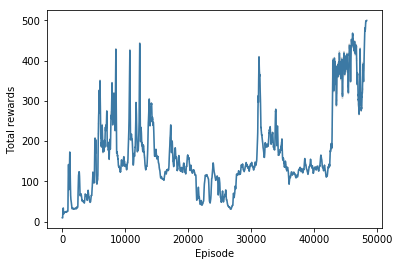

In [34]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

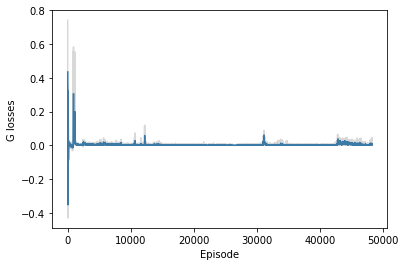

In [35]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

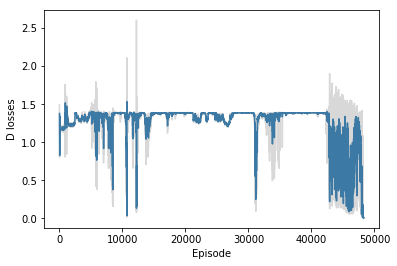

In [36]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [37]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.